In [1]:
using Revise
photochemistry_source_dir = "$(@__DIR__)/Photochemistry/src/"
println("loading Photochemistry.jl from $photochemistry_source_dir")
push!(LOAD_PATH, photochemistry_source_dir)
using Photochemistry  # custom module
using XLSX
using PyPlot
using DataFrames

loading Photochemistry.jl from /home/emc/OneDrive-CU/Research/UpperAtmoDH/Code/Photochemistry/src/


In [2]:
include("CONSTANTS.jl");

In [3]:
include("CUSTOMIZATIONS.jl");

In [4]:
include("PARAMETERS.jl")

Any[:NO2, :CN, :HNO, :NH, :NH2, :C, :CH, :CO2pl, :HCO2pl, :DCO2pl, :Opl, :O2pl, :Arpl, :ArHpl, :ArDpl, :Cpl, :CHpl, :CNpl, :COpl, :Hpl, :Dpl, :H2pl, :HDpl, :H3pl, :H2Dpl, :HD2pl, :H2Opl, :HDOpl, :H3Opl, :H2DOpl, :HO2pl, :HCOpl, :DCOpl, :HOCpl, :DOCpl, :HCNpl, :HCNHpl, :HNOpl, :HN2Opl, :Npl, :NHpl, :NH2pl, :NH3pl, :N2pl, :N2Hpl, :N2Dpl, :N2Opl, :NOpl, :NO2pl, :OHpl, :ODpl]


26

# Pull in the spreadsheet

In [88]:
reaction_network_spreadsheet = "REACTION_NETWORK.xlsx"

"REACTION_NETWORK.xlsx"

# And the old, hand-coded network for comparison

In [94]:
include("reaction_network.jl")

1005-element Vector{Vector{Any}}:
 [[:CO2], [:CO, :O], :JCO2toCOpO]
 [[:CO2], [:CO, :O1D], :JCO2toCOpO1D]
 [[:O2], [:O, :O], :JO2toOpO]
 [[:O2], [:O, :O1D], :JO2toOpO1D]
 [[:O3], [:O2, :O], :JO3toO2pO]
 [[:O3], [:O2, :O1D], :JO3toO2pO1D]
 [[:O3], [:O, :O, :O], :JO3toOpOpO]
 [[:H2], [:H, :H], :JH2toHpH]
 [[:HD], [:H, :D], :JHDtoHpD]
 [[:OH], [:O, :H], :JOHtoOpH]
 [[:OH], [:O1D, :H], :JOHtoO1DpH]
 [[:OD], [:O, :D], :JODtoOpD]
 [[:OD], [:O1D, :D], :JODtoO1DpD]
 ⋮
 [[:NH2pl, :E], [:NH, :H], :((8.34e-6 .* Te .^ -0.79) .* exp.(-17.1 ./ Te))]
 [[:NH3pl, :E], [:NH, :H, :H], :(2.68e-6 .* Te .^ -0.5)]
 [[:NH3pl, :E], [:NH2, :H], :(2.68e-6 .* Te .^ -0.5)]
 [[:NHpl, :E], [:N, :H], :(7.45e-7 .* Te .^ -0.5)]
 [[:NO2pl, :E], [:NO, :O], :(5.2e-6 .* Te .^ -0.5)]
 [[:NOpl, :E], [:O, :Nup2D], :((0.95 .* 6.928e-6) .* Te .^ -0.5)]
 [[:NOpl, :E], [:O, :N], :((0.05 .* 6.928e-6) .* Te .^ -0.5)]
 [[:Npl, :E], [:N], :(1.9e-10 .* Te .^ -0.7)]
 [[:O2pl, :E], [:O, :O], :(8.15e-6 .* Te .^ -0.65)]
 [[:OHpl, :E], [:O

# Get the new auto-generated networks

In [90]:
ionnet = format_ion_network(reaction_network_spreadsheet, all_species);
Jrxns = [[[absorber[Jr]], photolysis_products[Jr], Jr] for Jr in Jratelist];
neutral_net = format_neutral_network(reaction_network_spreadsheet, all_species);


Removed reactions: 0×25 DataFrame
Removed reactions: 12×26 DataFrame
 Row │ No   R1     R2    R3    P1   P2    P3    type  M2   M1   pow  BR   kA       kB   kC    k0A  k0B  k0C  kradA  kradB  kradC  F    Trange    Reference  Notes    Added by
     │ Any  Any    Any   Any   Any  Any   Any   Any   Any  Any  Any  Any  Any      Any  Any   Any  Any  Any  Any    Any    Any    Any  Any       Any        Any      Any
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    Nup2D  none  none  N    none  none  1     1    1    0    1    2.3e-5   0    0     0    0    0    0      0      0      0    195-1000  Okabe78    missing  Yelle
   2 │ 172  Nup2D  CO    none  CO   N     none  2     1    1    0    1    1.9e-12  0    0     0    0    0    0      0      0      0    298       Herron99   missing  Yelle
   3 │ 173  Nup2D  CO2   none  NO   CO    none  2     1    1    0    1 

# Compile the final network

In [95]:
new_auto_reaction_network = [Jrxns..., neutral_net..., ionnet...]


1009-element Vector{Vector{Any}}:
 [[:CO2], [:CO, :O], :JCO2toCOpO]
 [[:CO2], [:CO, :O1D], :JCO2toCOpO1D]
 [[:O2], [:O, :O], :JO2toOpO]
 [[:O2], [:O, :O1D], :JO2toOpO1D]
 [[:O3], [:O2, :O], :JO3toO2pO]
 [[:O3], [:O2, :O1D], :JO3toO2pO1D]
 [[:O3], [:O, :O, :O], :JO3toOpOpO]
 [[:H2], [:H, :H], :JH2toHpH]
 [[:OH], [:O, :H], :JOHtoOpH]
 [[:OH], [:O1D, :H], :JOHtoO1DpH]
 [[:HO2], [:OH, :O], :JHO2toOHpO]
 [[:H2O], [:H, :OH], :JH2OtoHpOH]
 [[:H2O], [:H2, :O1D], :JH2OtoH2pO1D]
 ⋮
 [[:NH2pl, :E], [:NH, :H], :((8.34e-6 .* Te .^ -0.79) .* exp.(-17.1 ./ Te))]
 [[:NH3pl, :E], [:NH, :H, :H], :(2.68e-6 .* Te .^ -0.5)]
 [[:NH3pl, :E], [:NH2, :H], :(2.68e-6 .* Te .^ -0.5)]
 [[:NHpl, :E], [:N, :H], :(7.45e-7 .* Te .^ -0.5)]
 [[:NO2pl, :E], [:NO, :O], :(5.2e-6 .* Te .^ -0.5)]
 [[:NOpl, :E], [:O, :N], :(3.4640000000000003e-7 .* Te .^ -0.5)]
 [[:NOpl, :E], [:O, :Nup2D], :(6.5816e-6 .* Te .^ -0.5)]
 [[:Npl, :E], [:N], :(1.9e-10 .* Te .^ -0.7)]
 [[:O2pl, :E], [:O, :O], :(8.15e-6 .* Te .^ -0.65)]
 [[:ODpl, :E

In [92]:
println(length([neutral_net..., ionnet...]))

945


In [59]:
for i in new_auto_reaction_network
    if :Nup2D in i[1]
        println(i)
    end
end

# Get a test atmosphere

In [9]:
nc = get_ncurrent("converged_gear_20211231.h5");

# Compare J rates

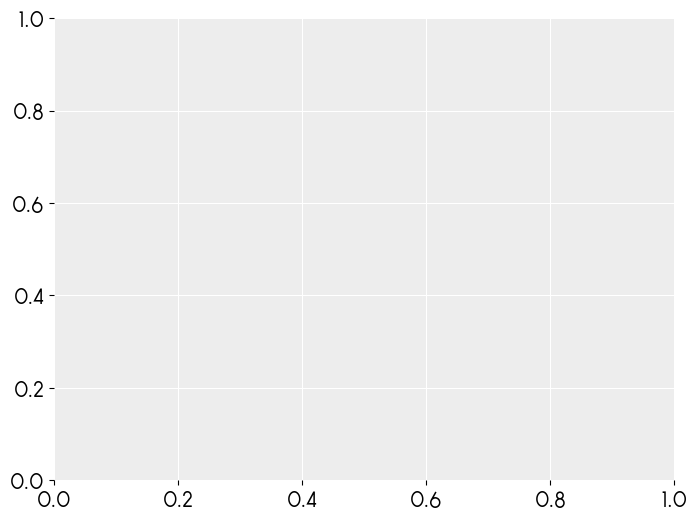

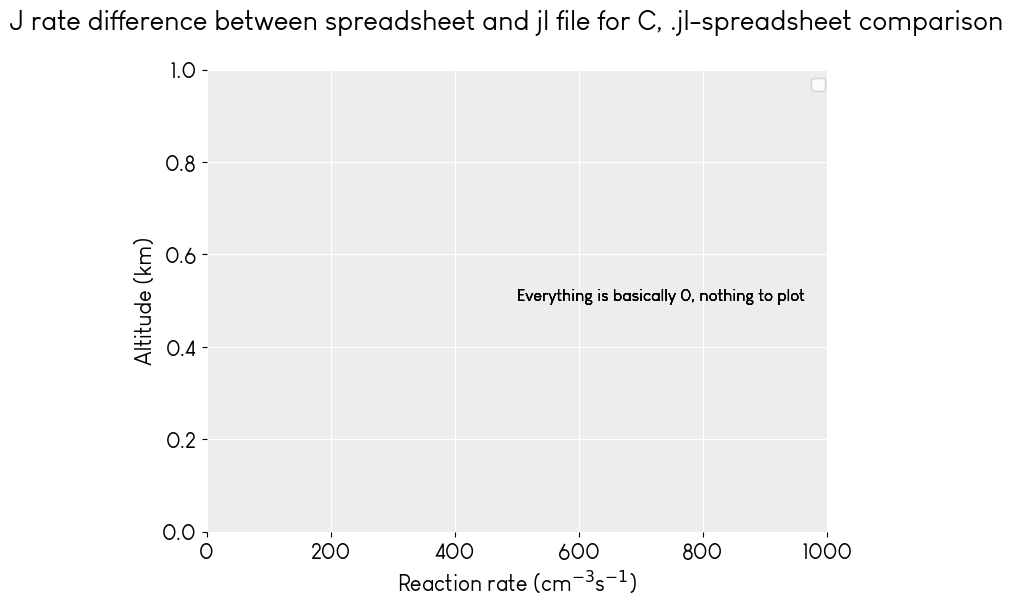

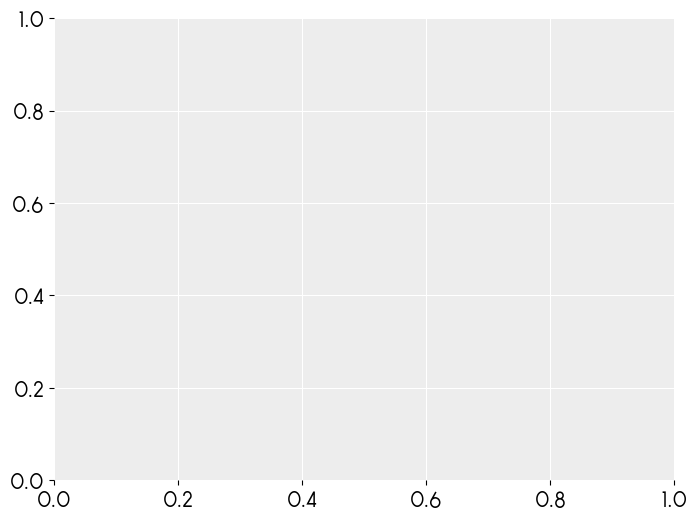

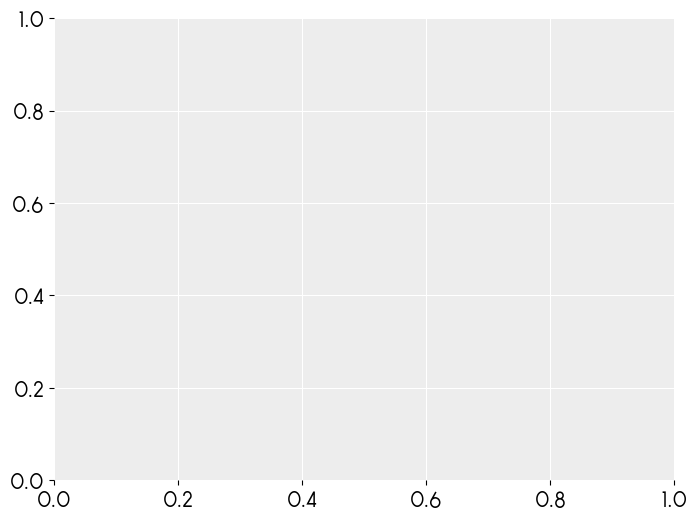

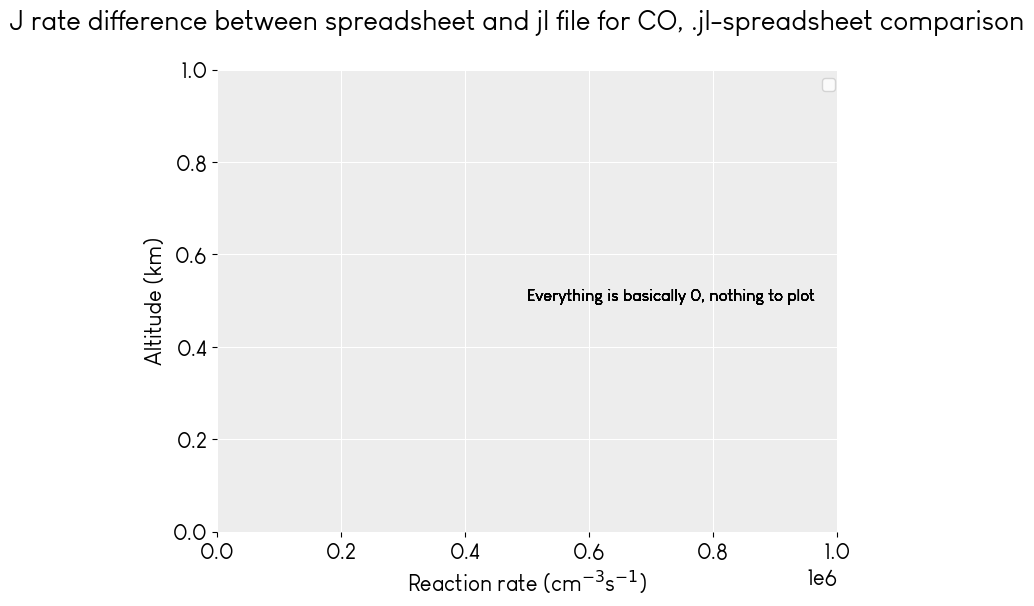

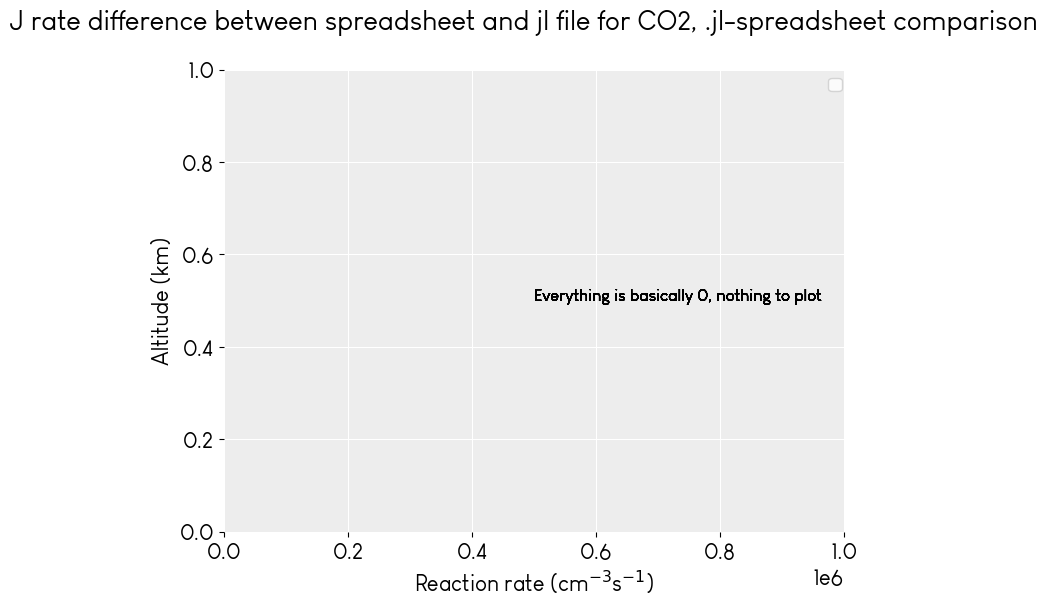

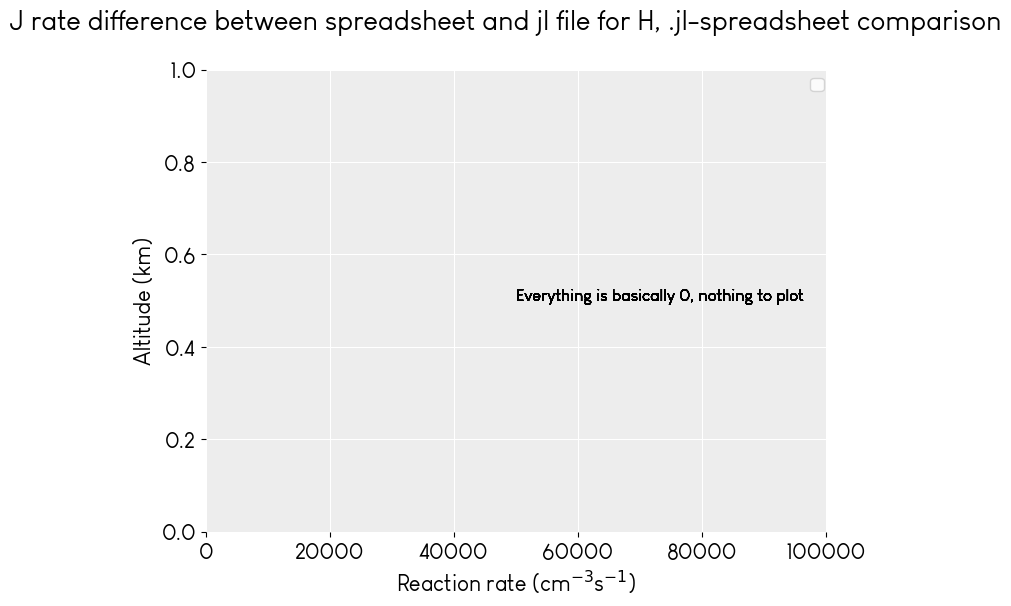

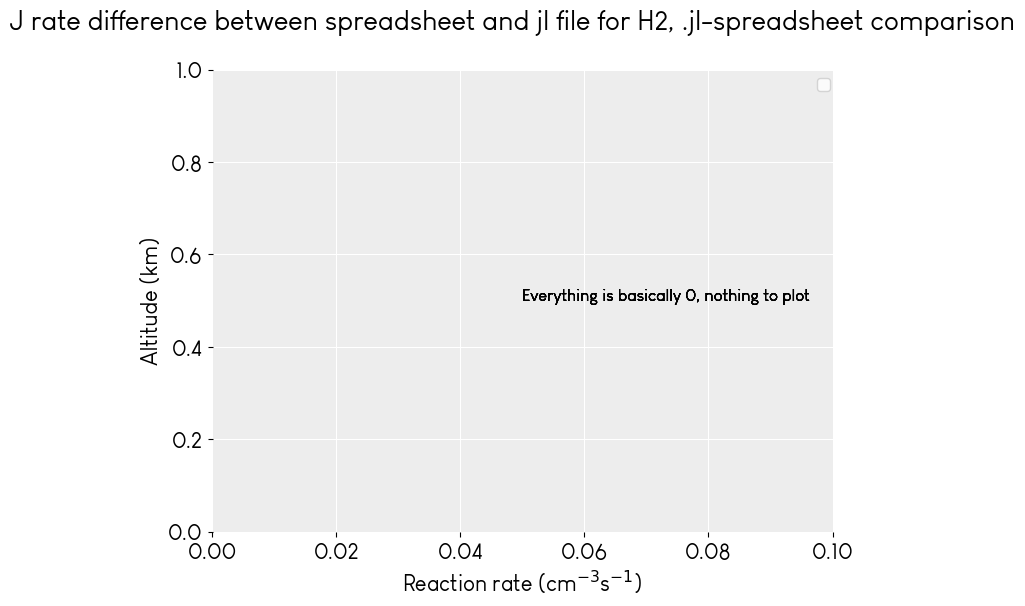

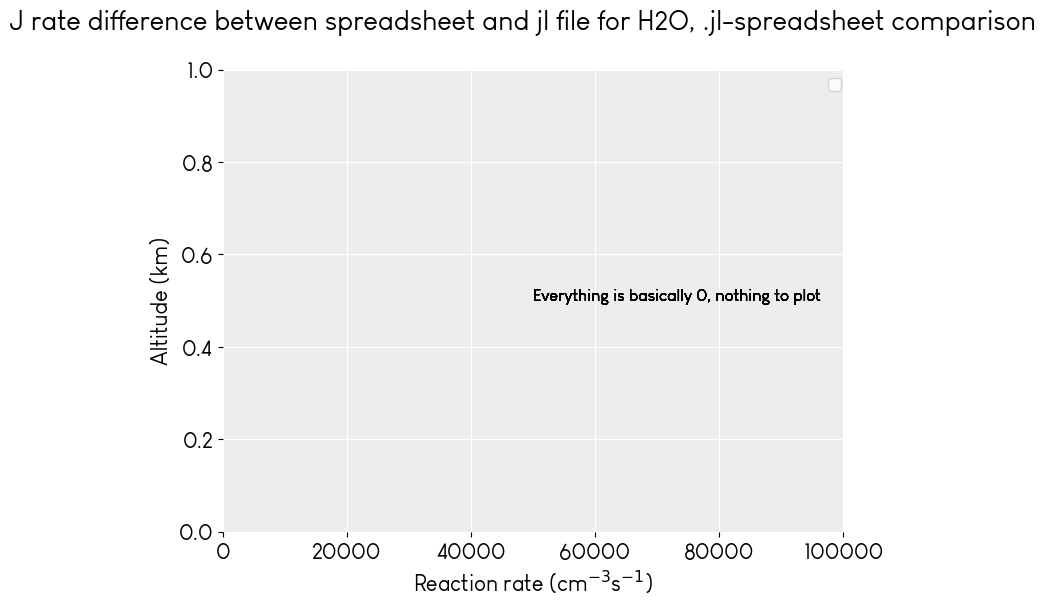

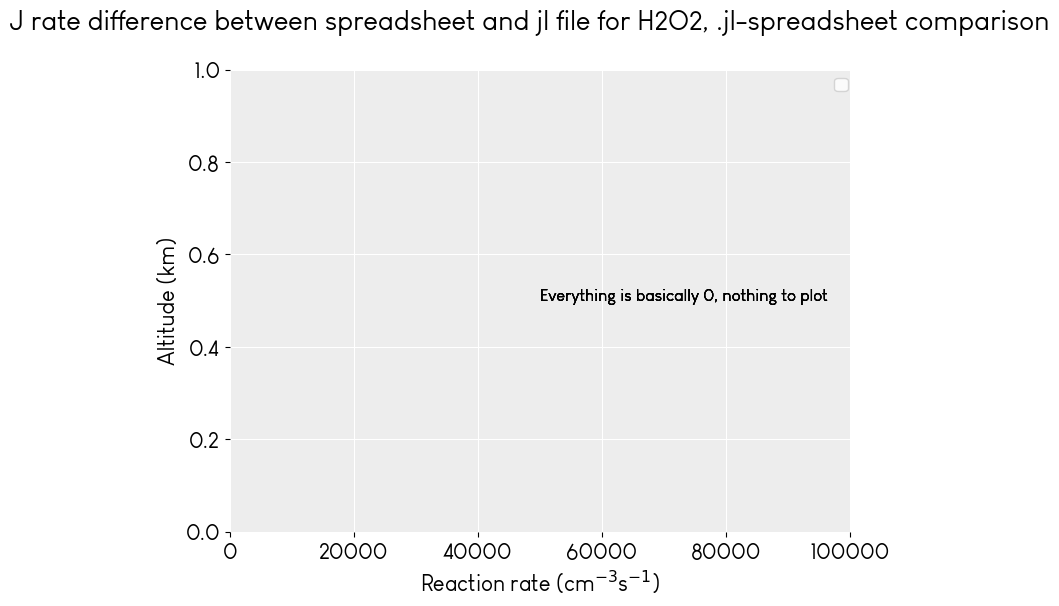

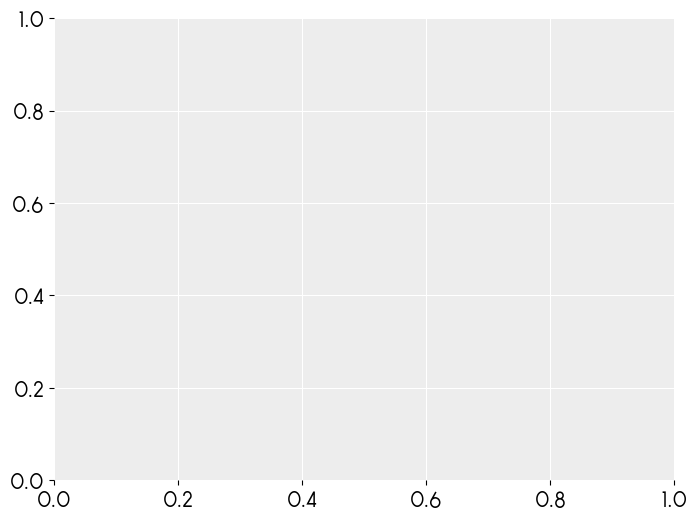

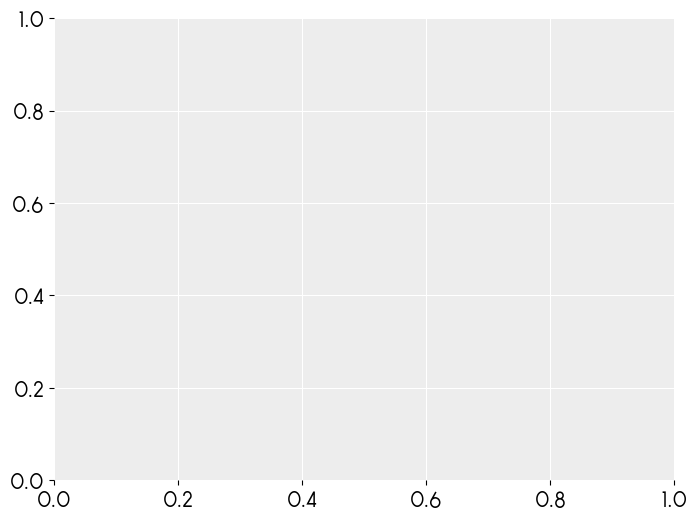

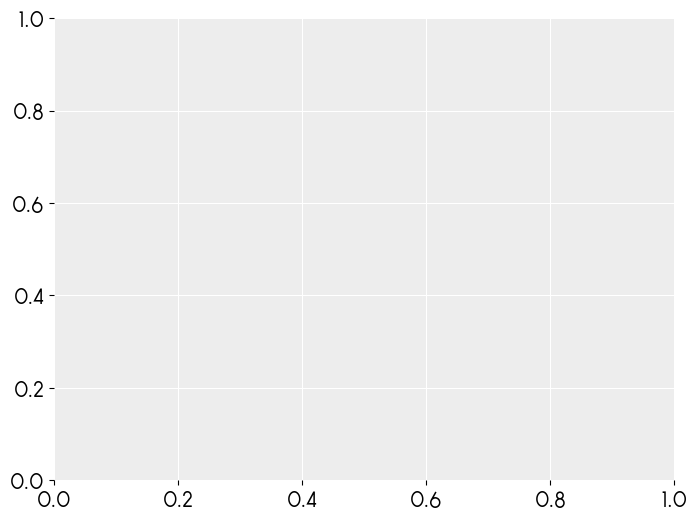

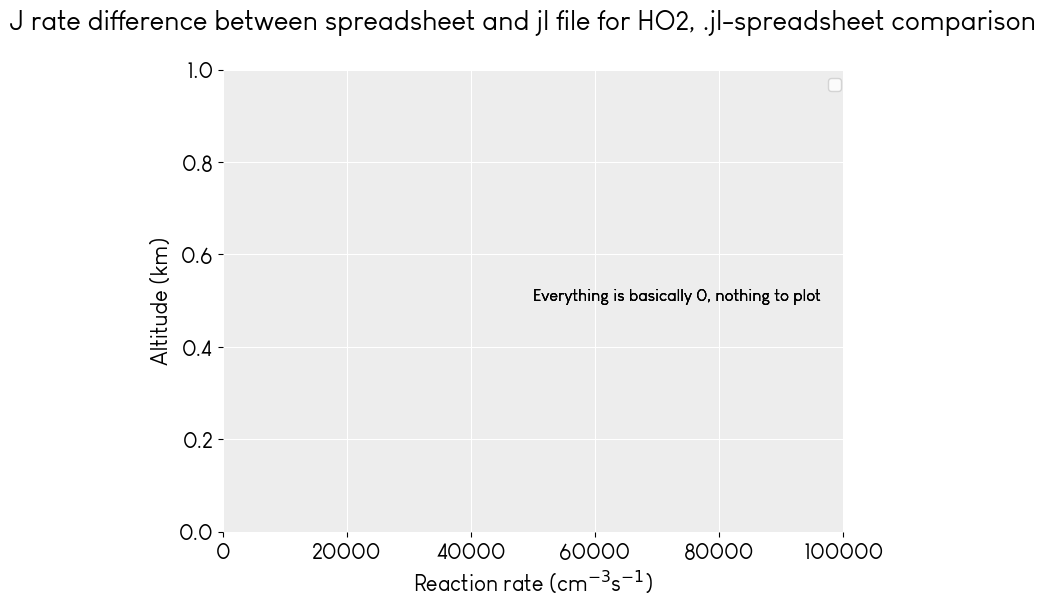

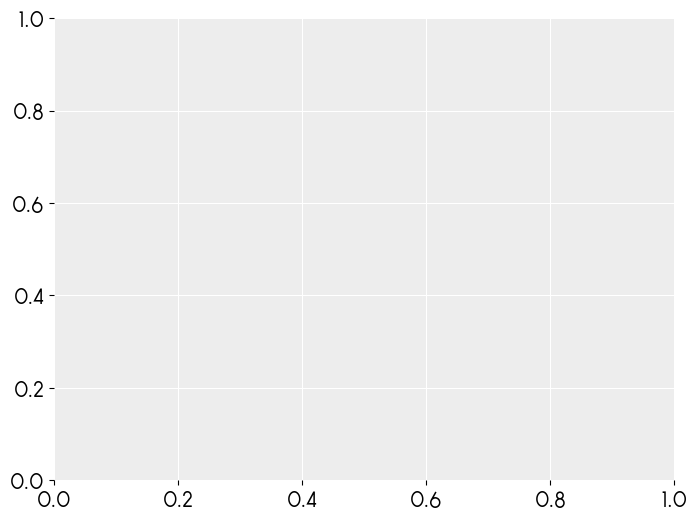

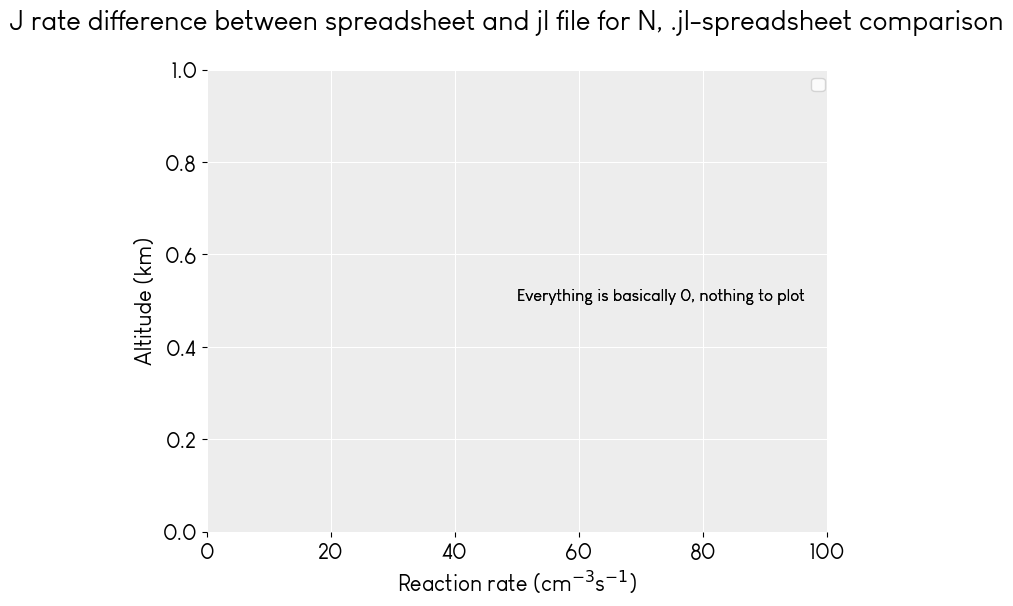

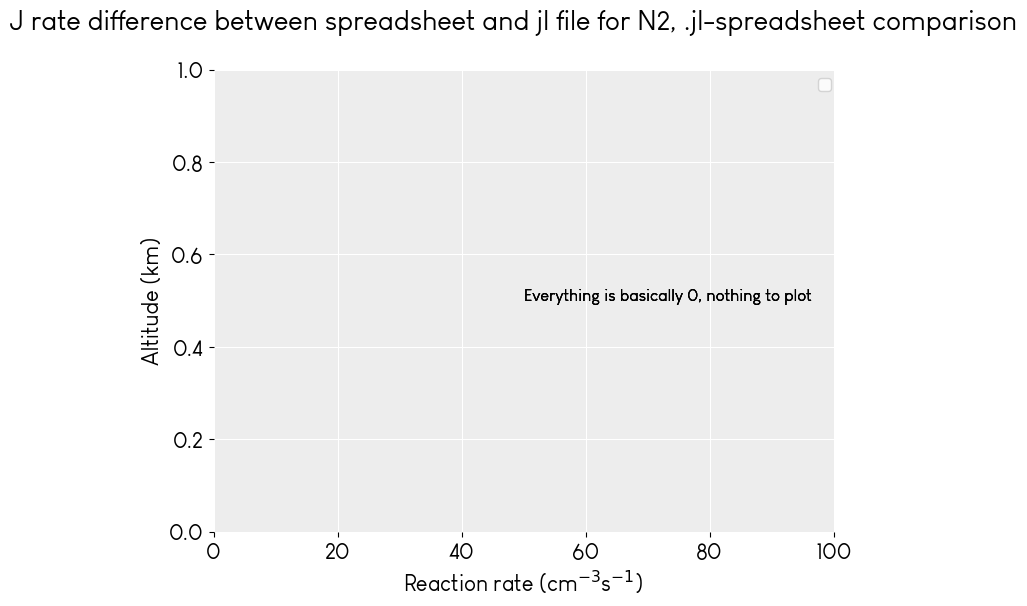

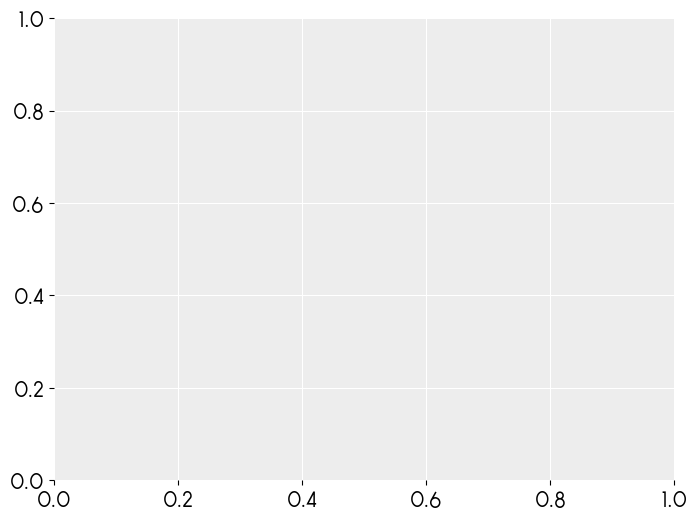

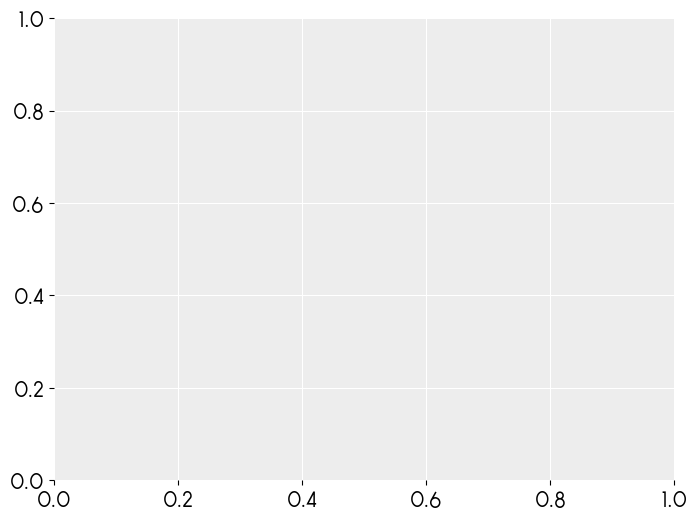

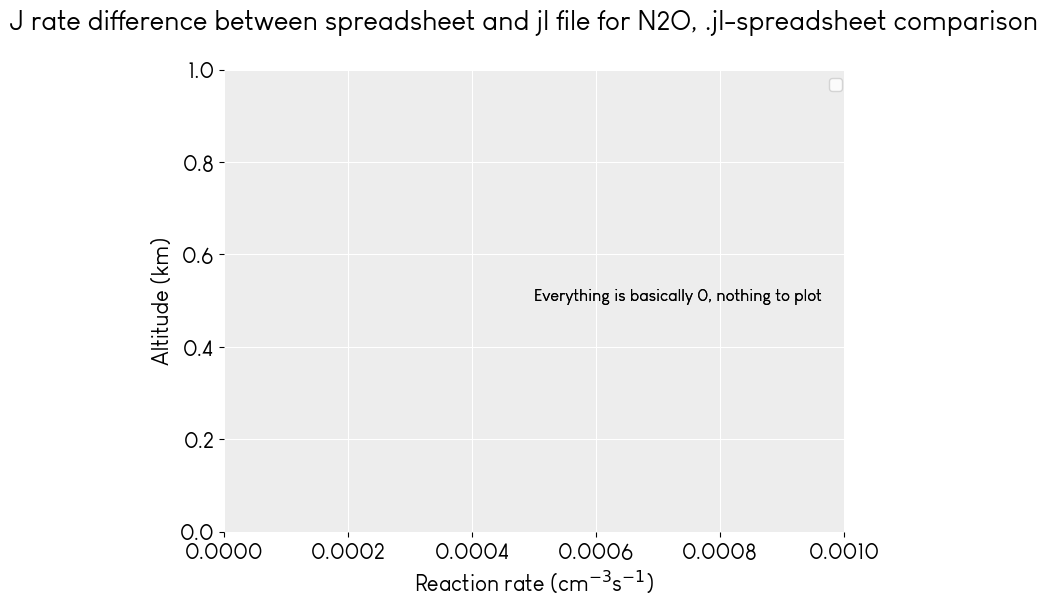

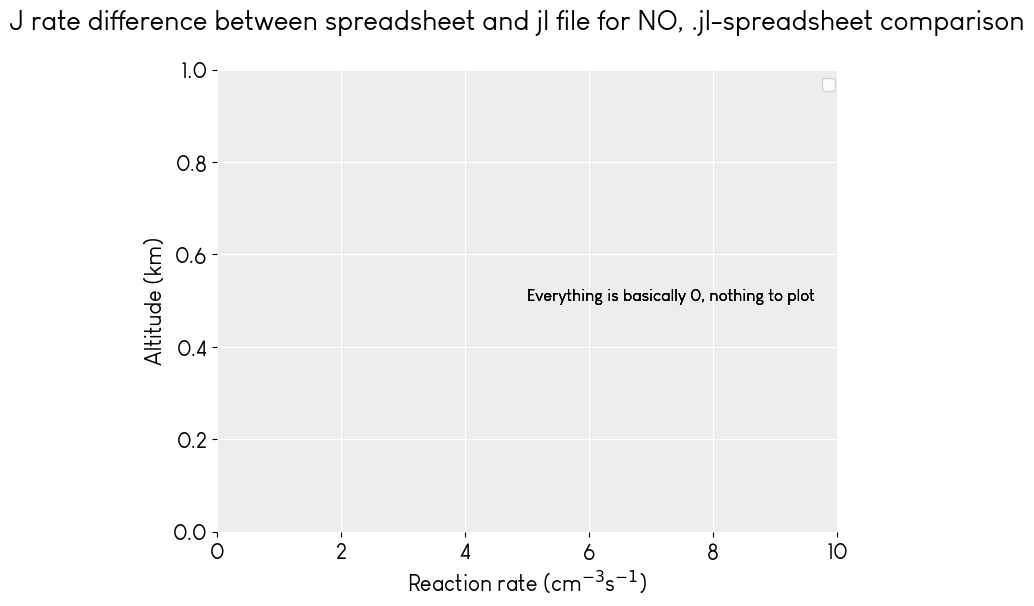

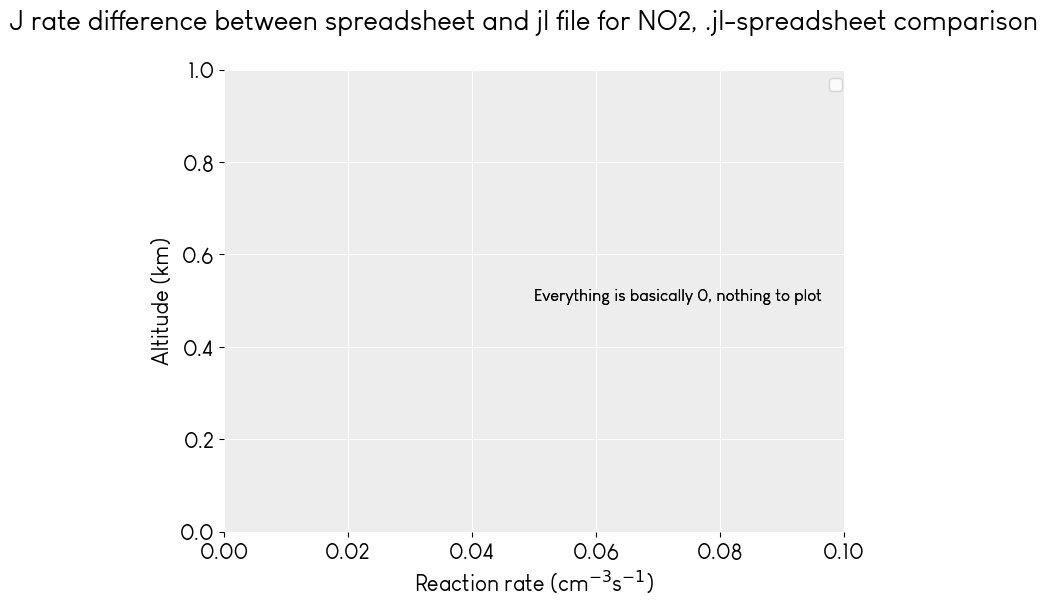

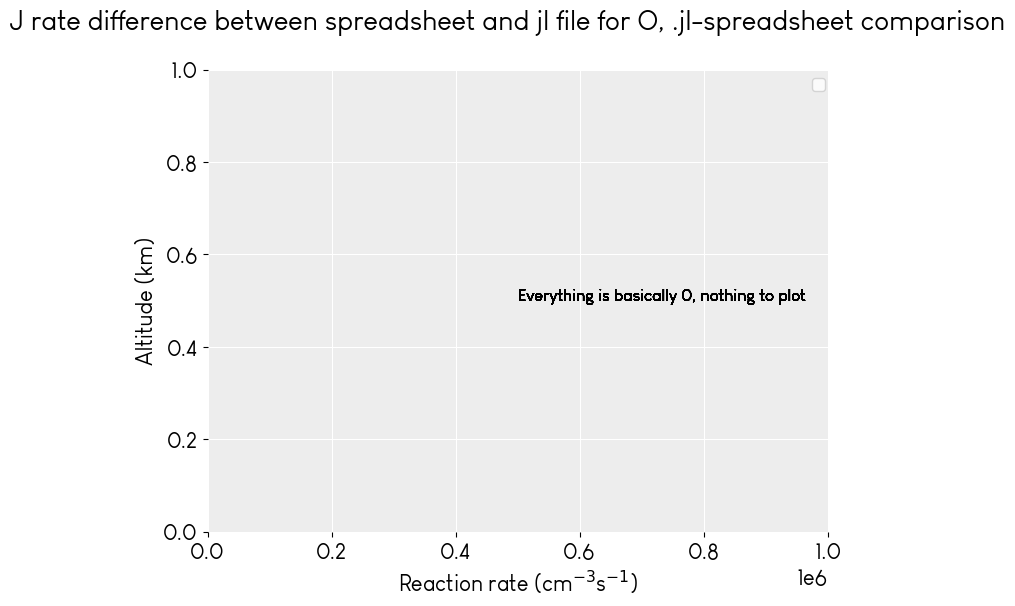

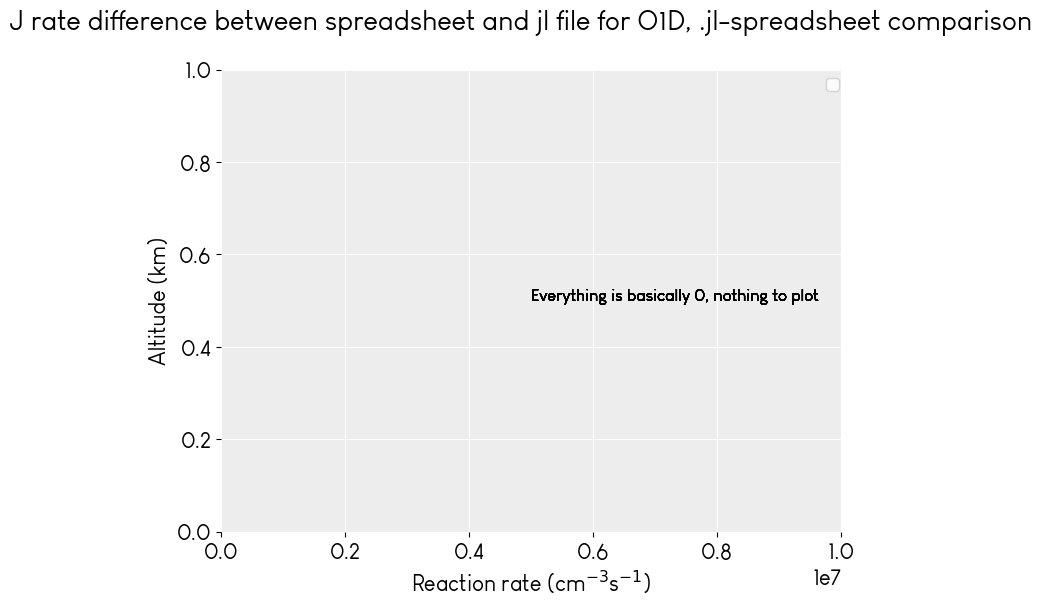

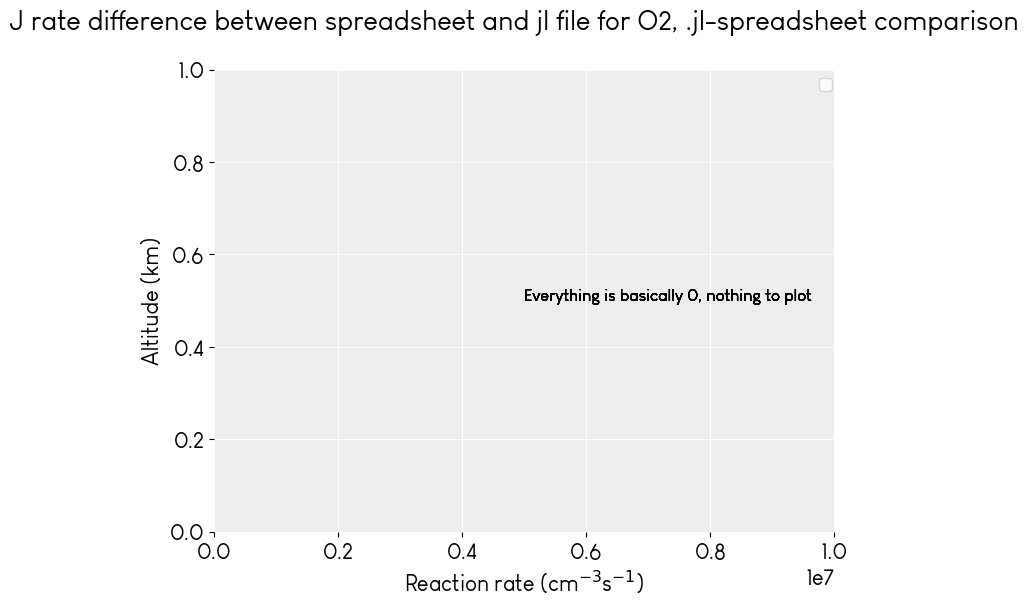

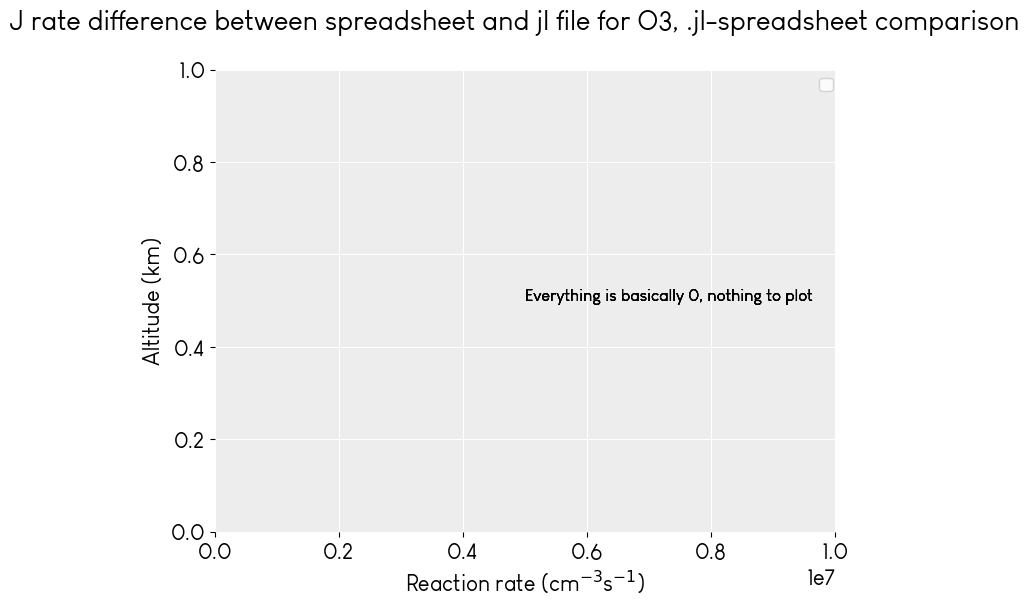

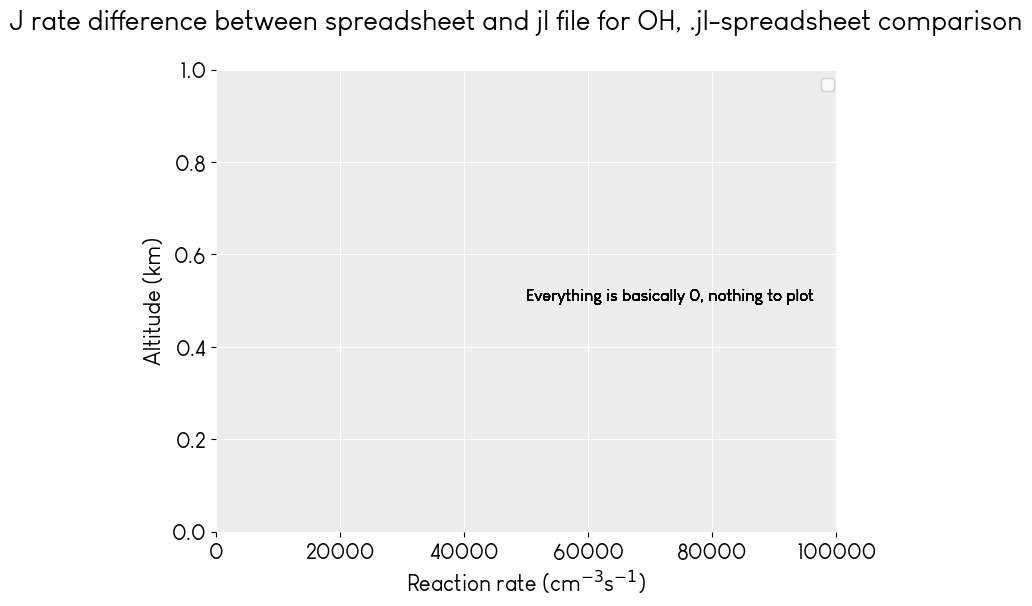

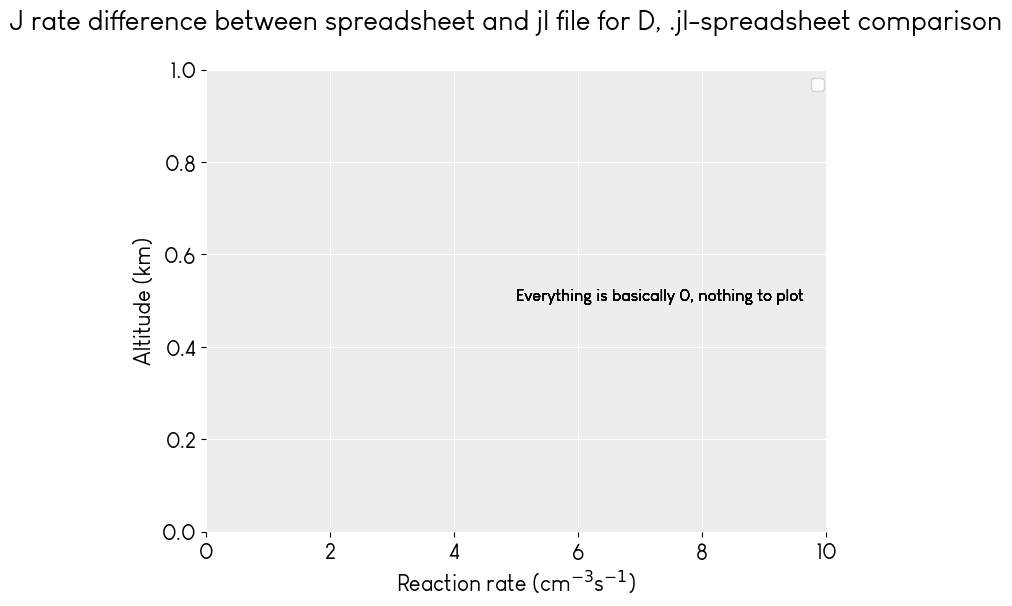

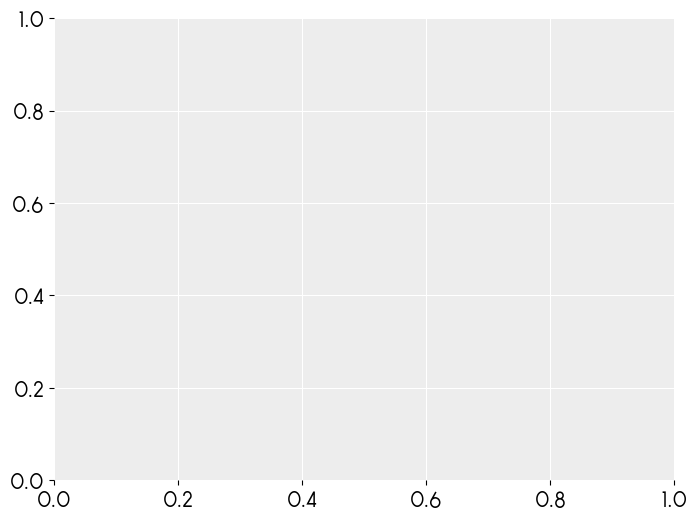

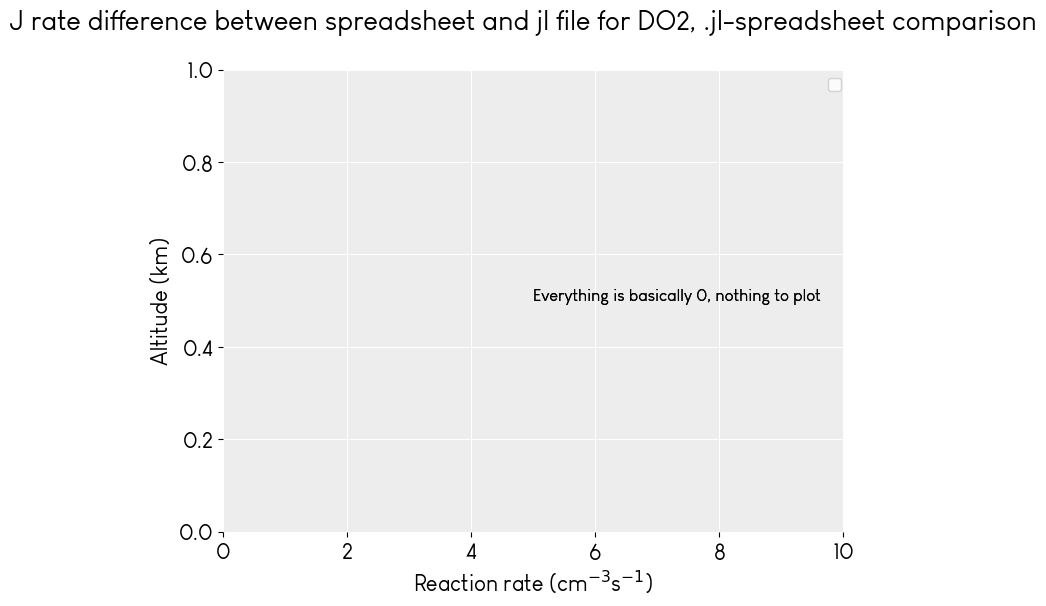

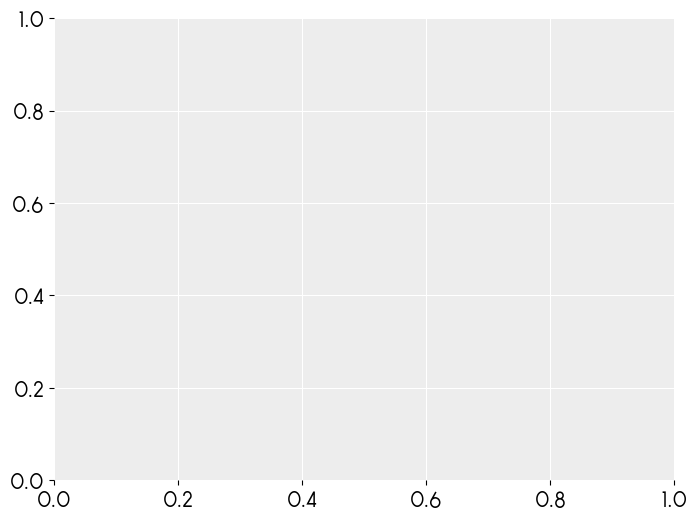

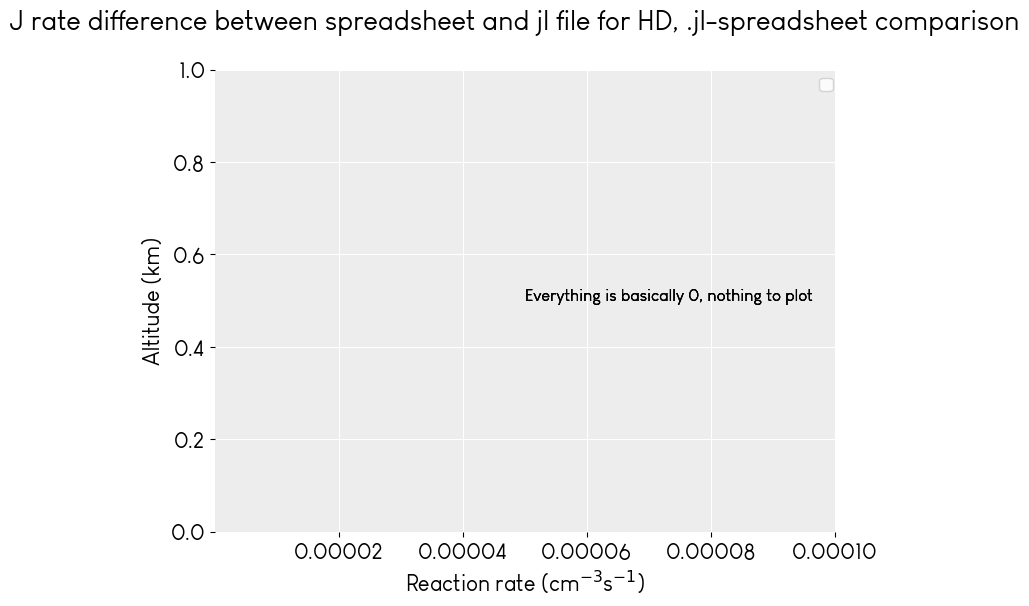

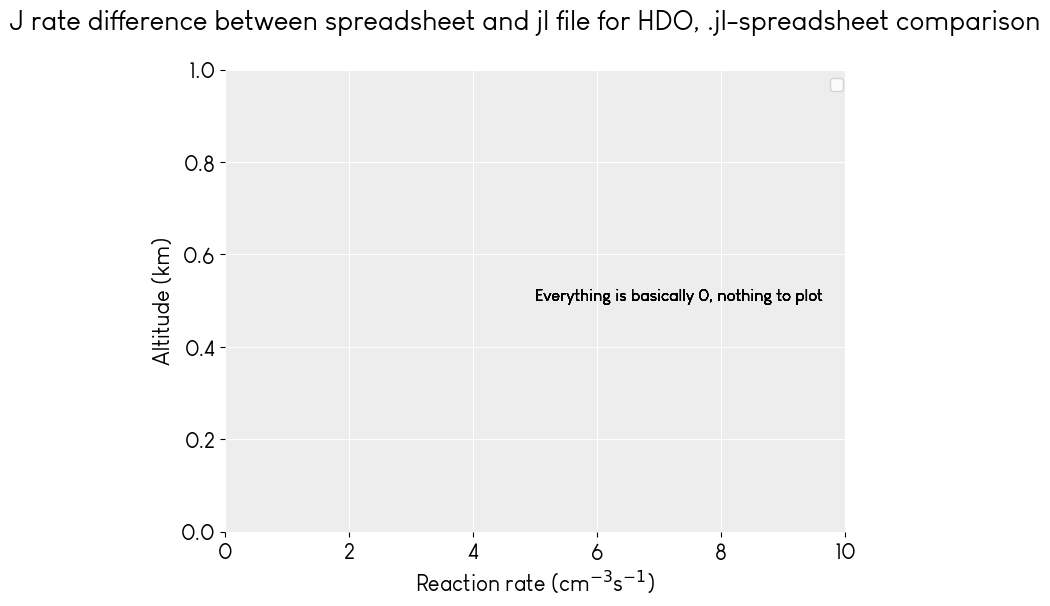

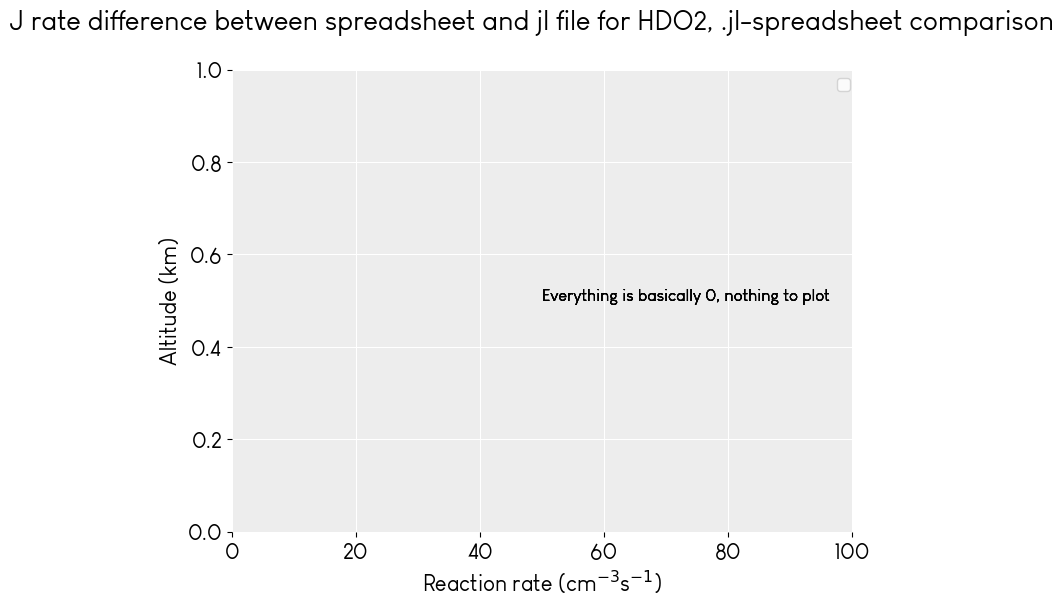

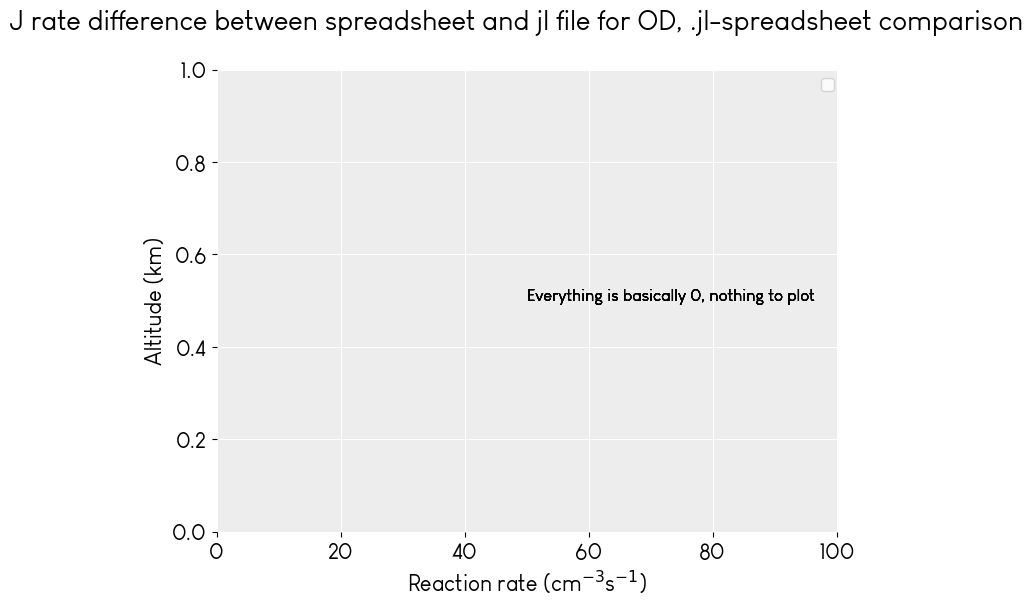

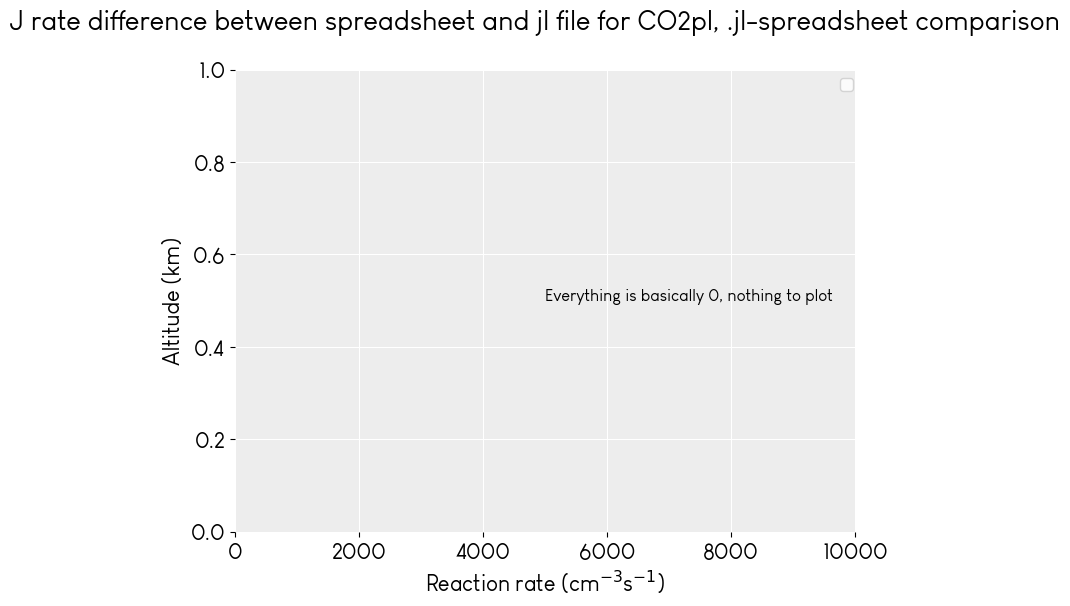

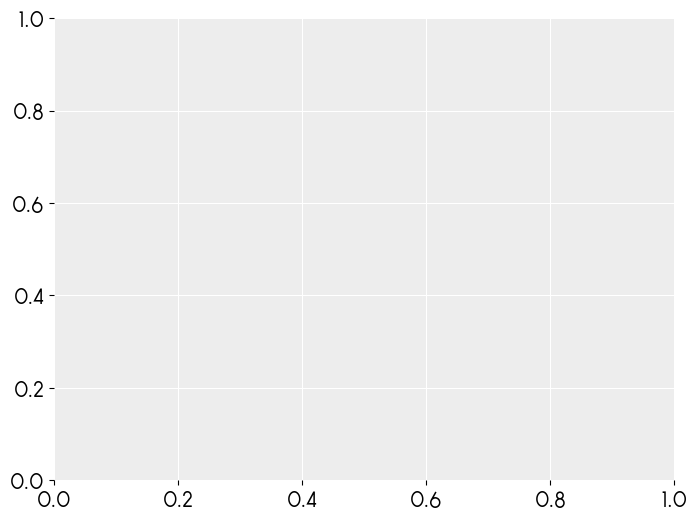

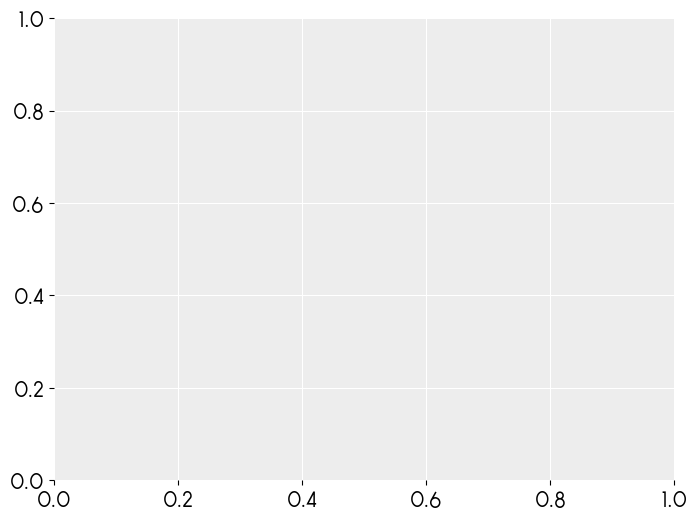

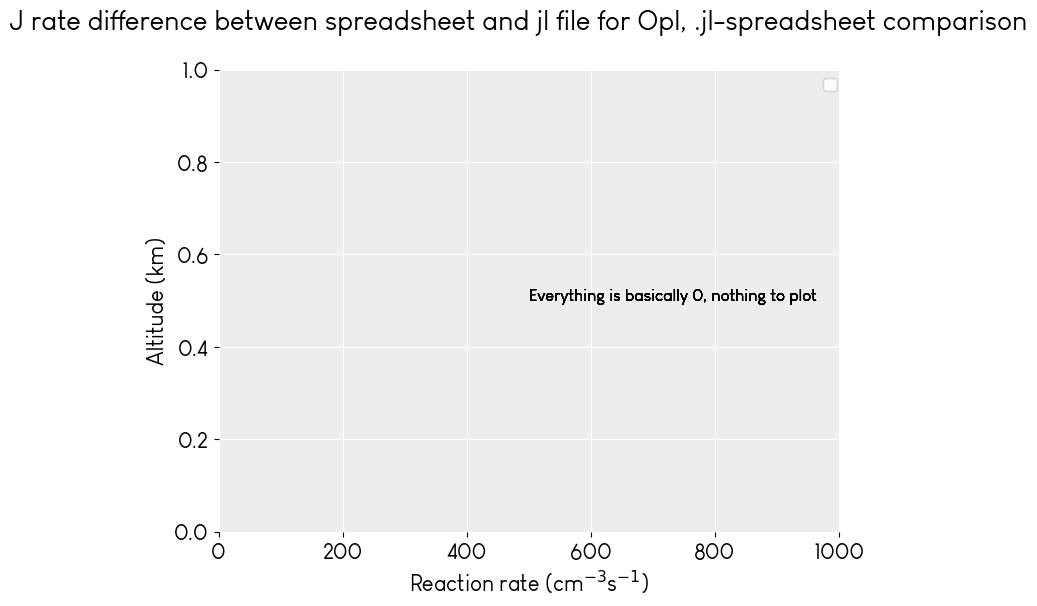

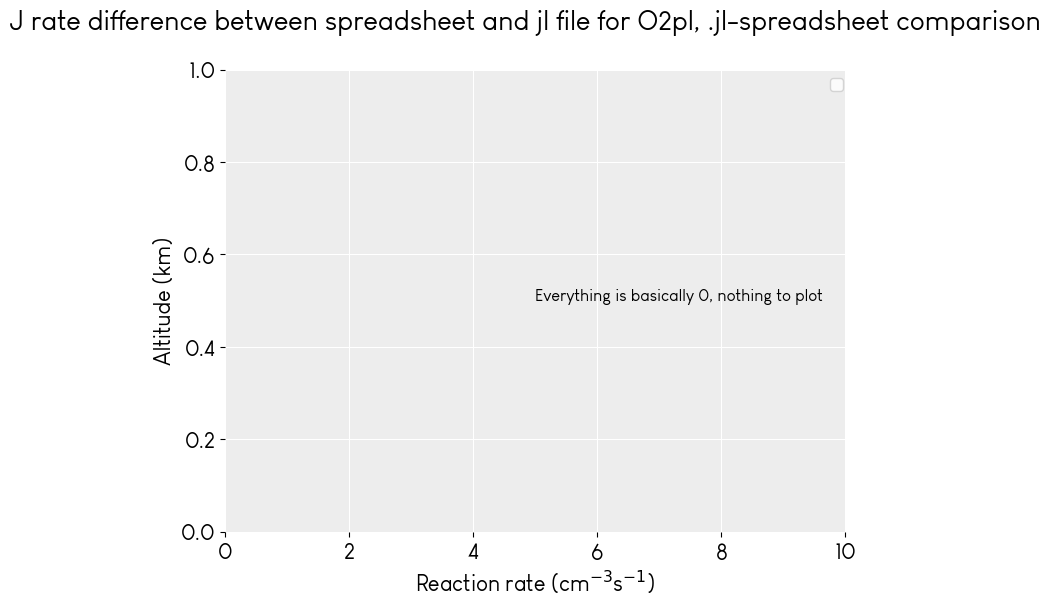

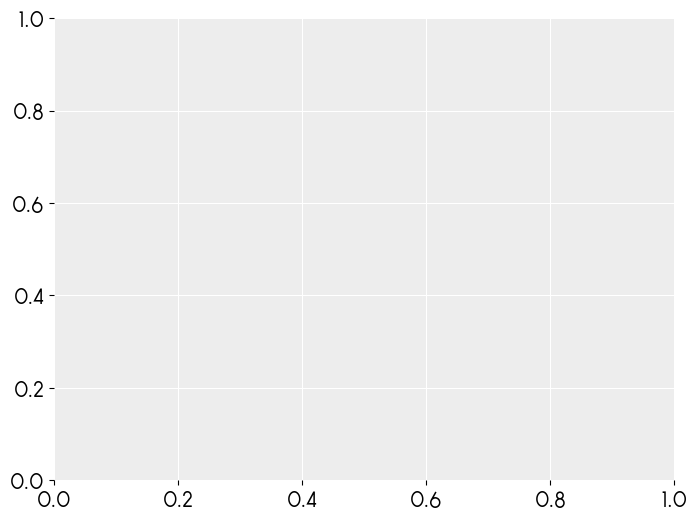

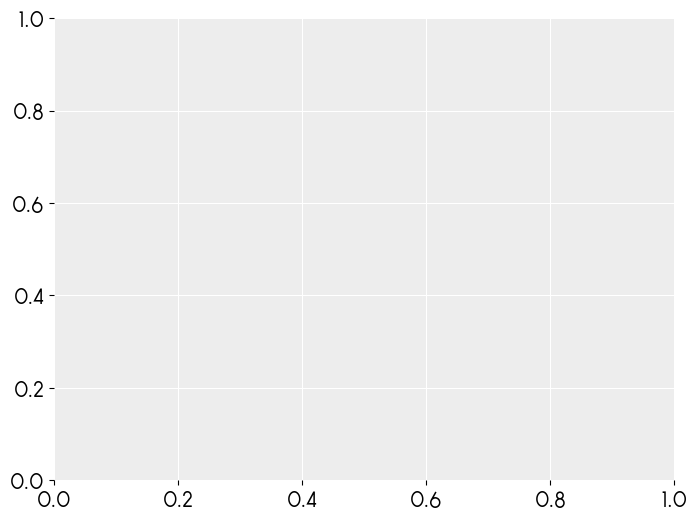

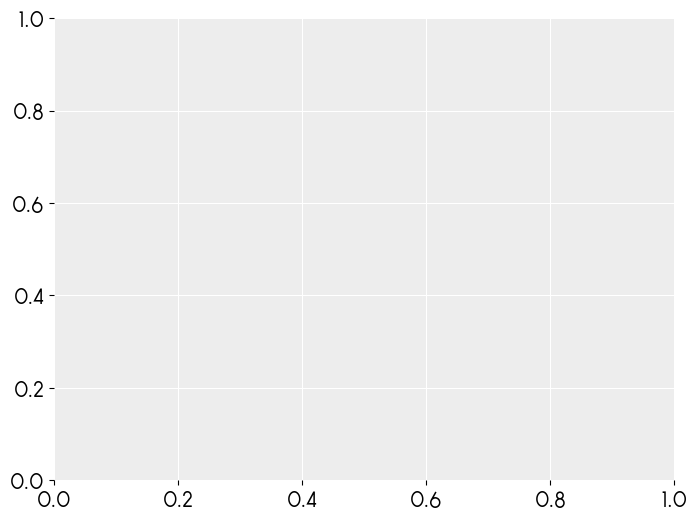

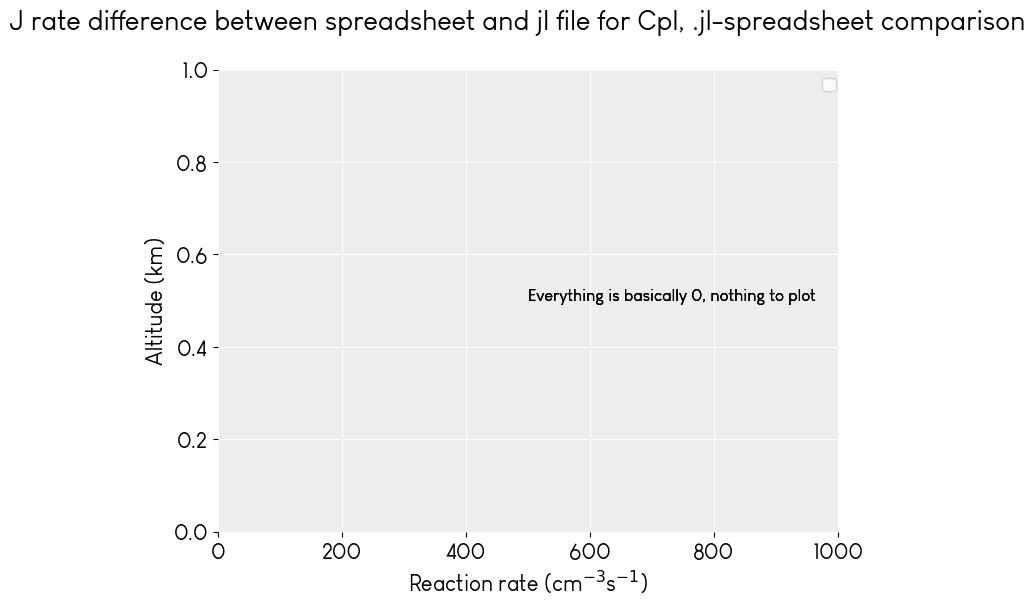

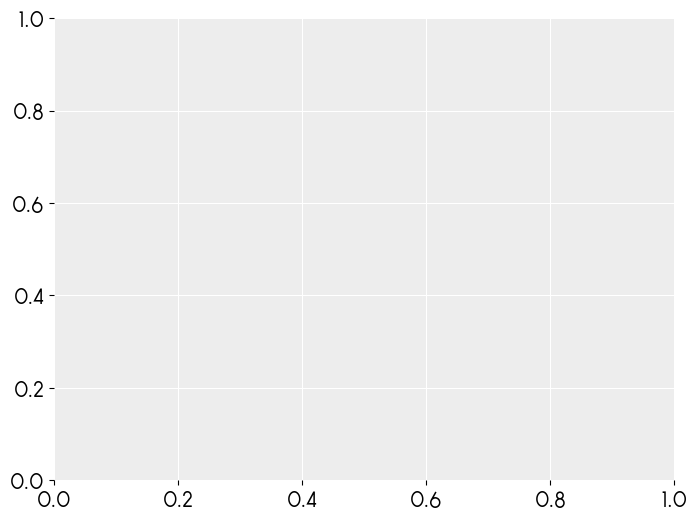

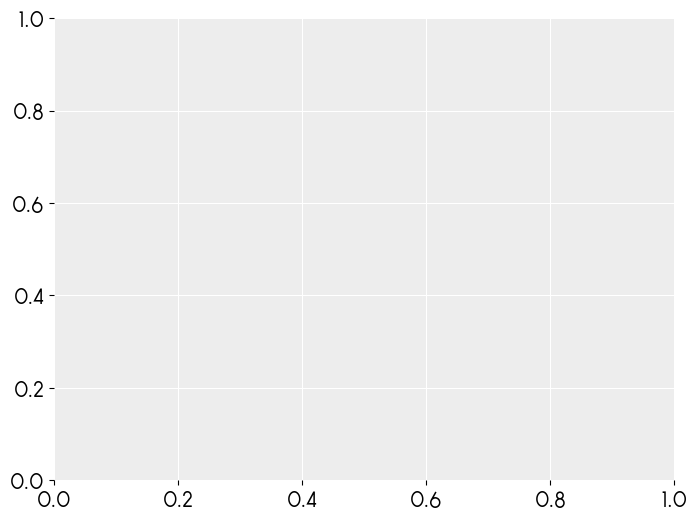

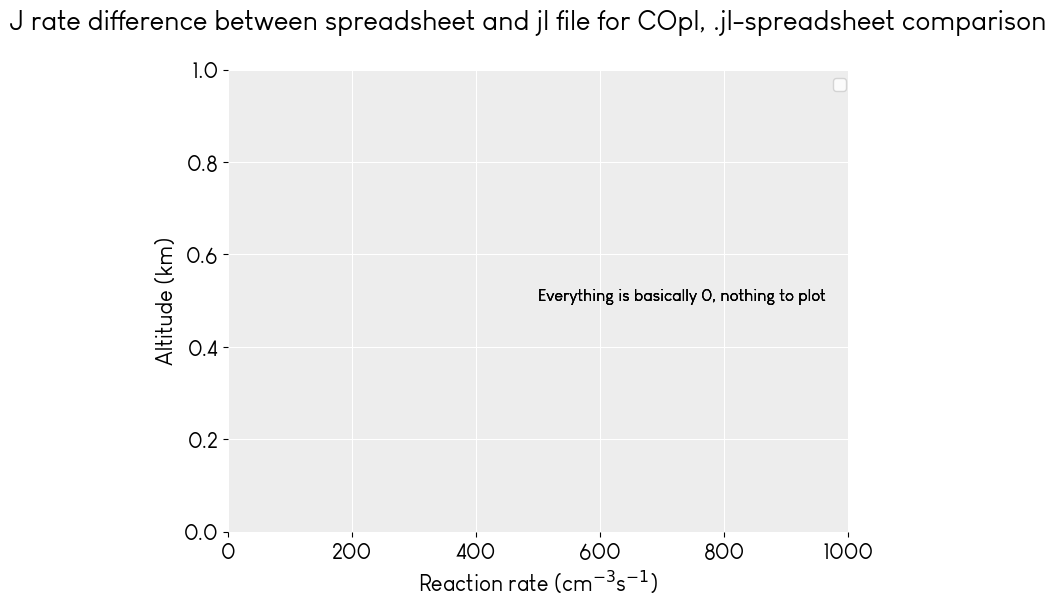

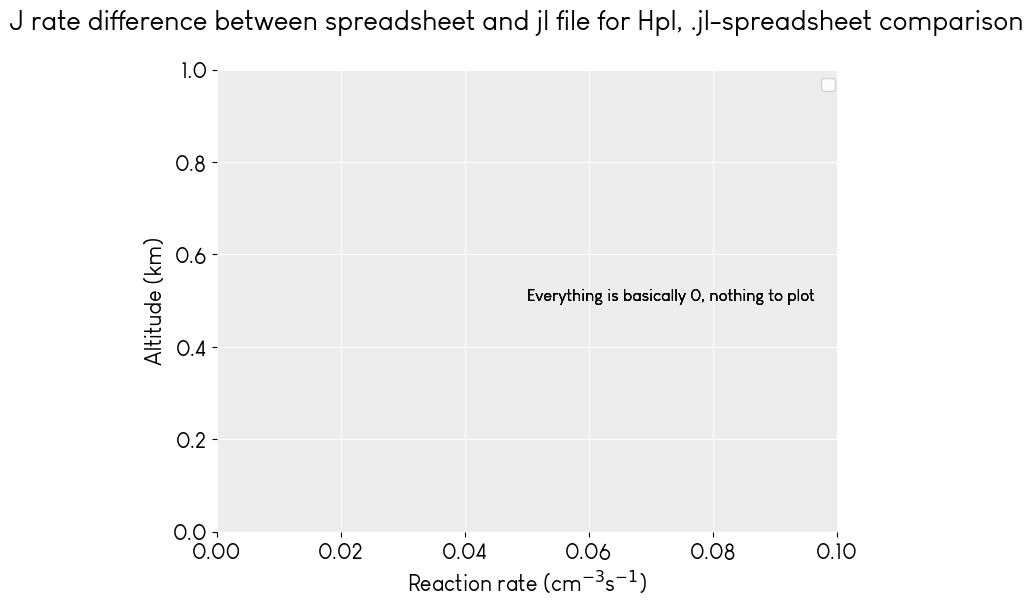

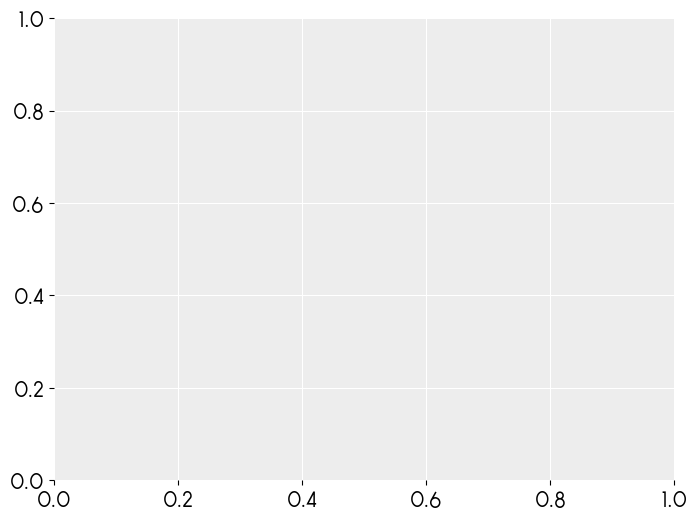

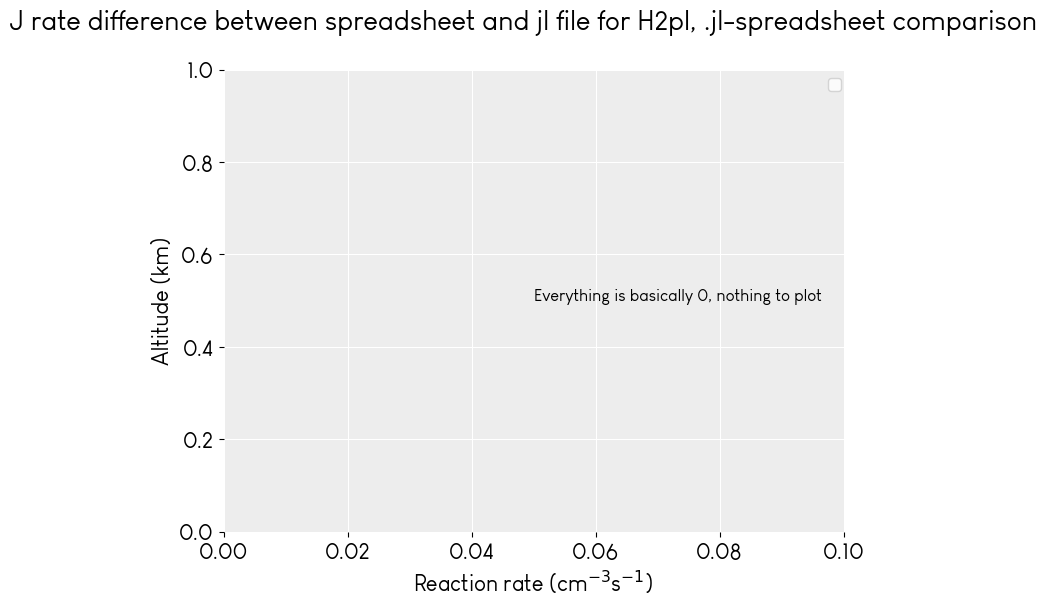

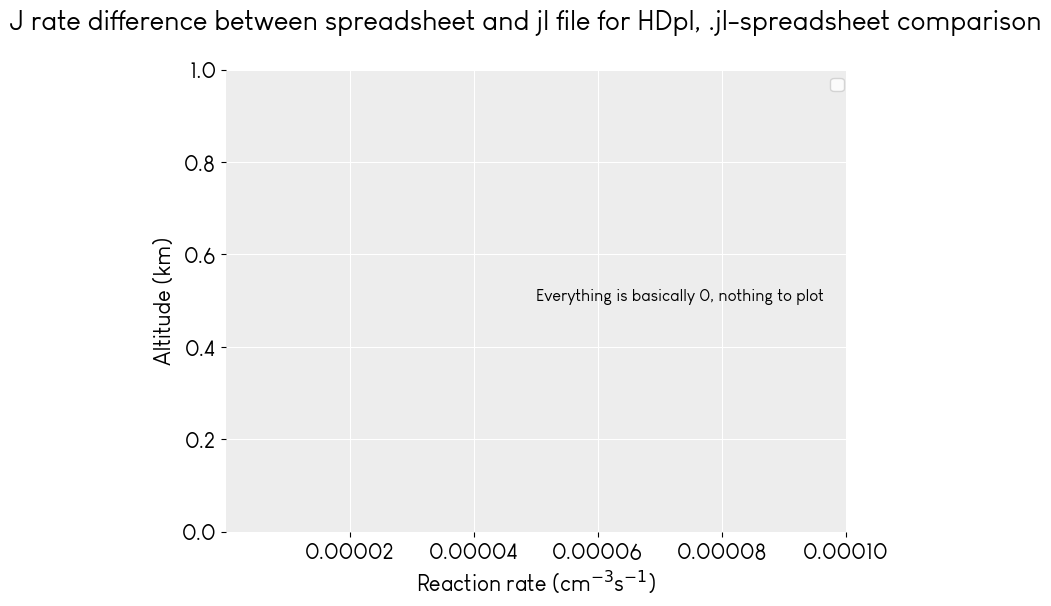

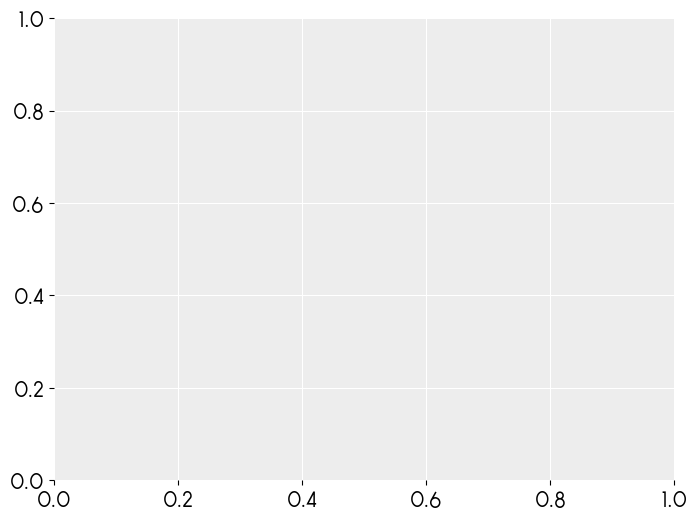

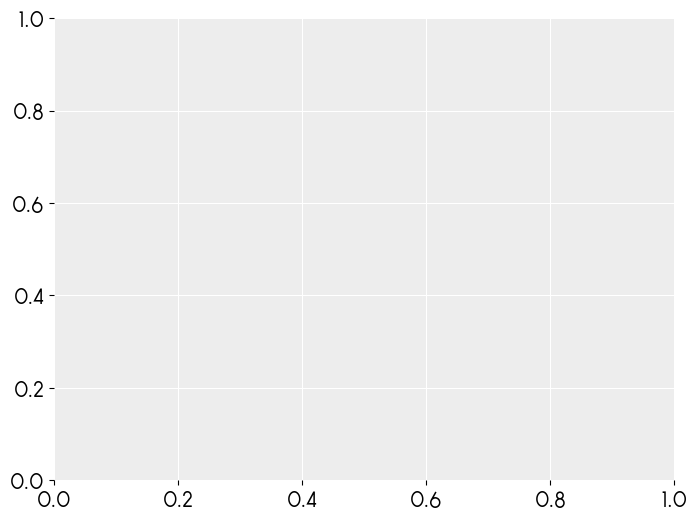

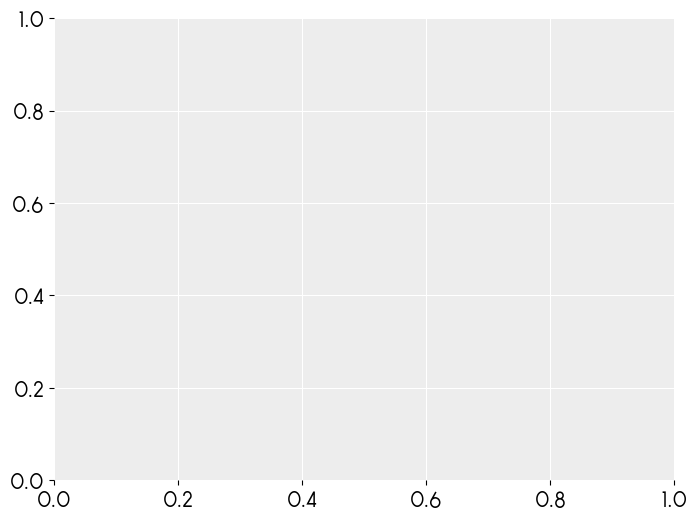

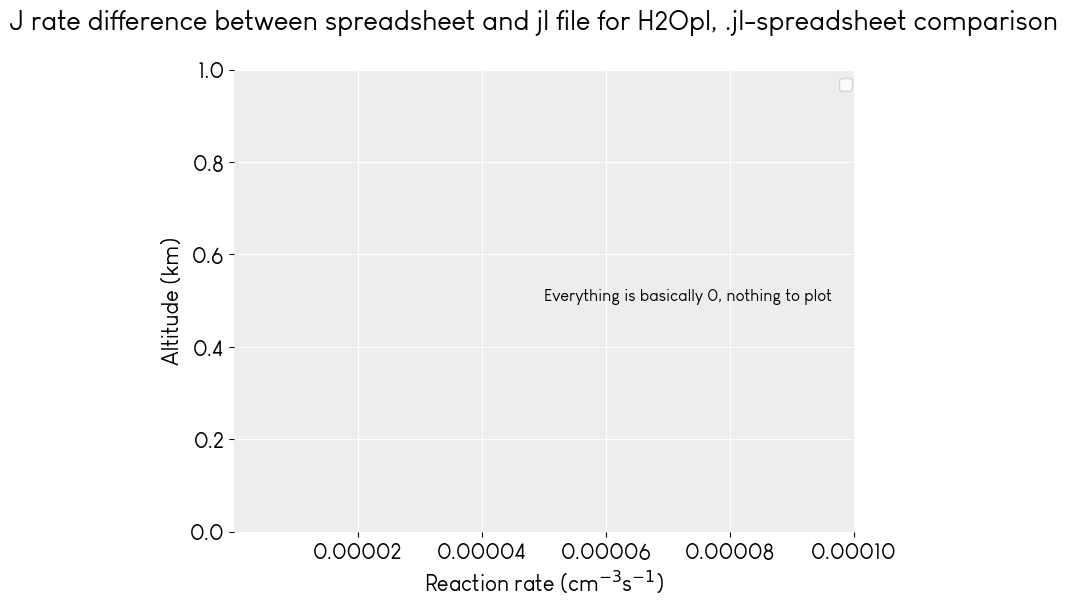

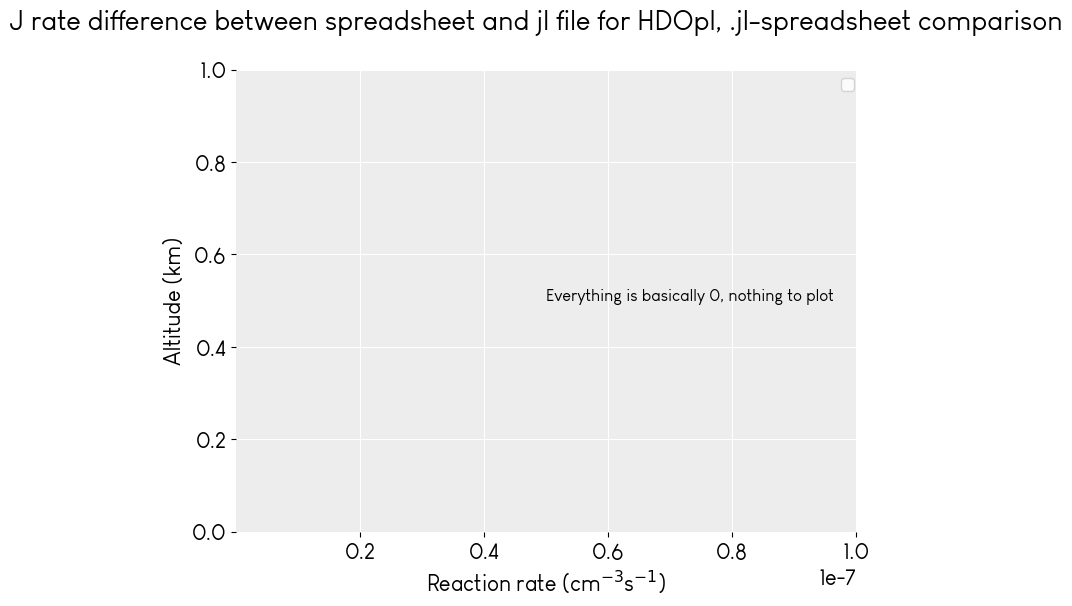

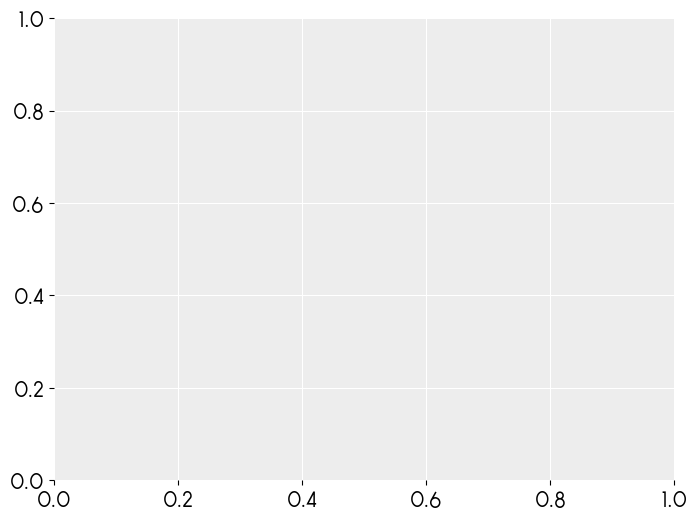

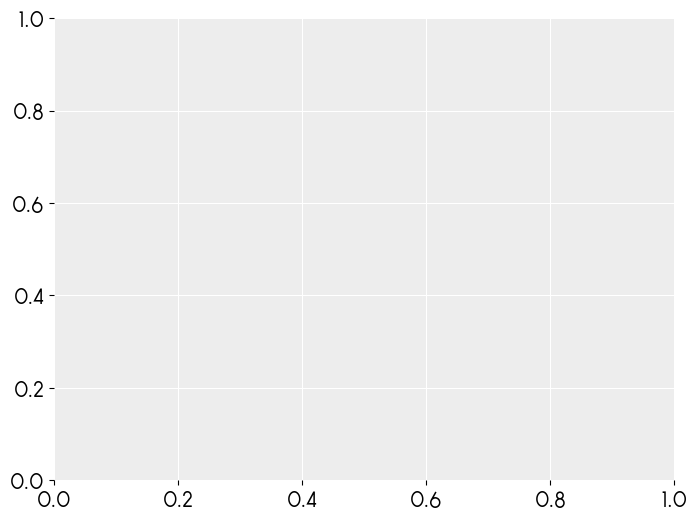

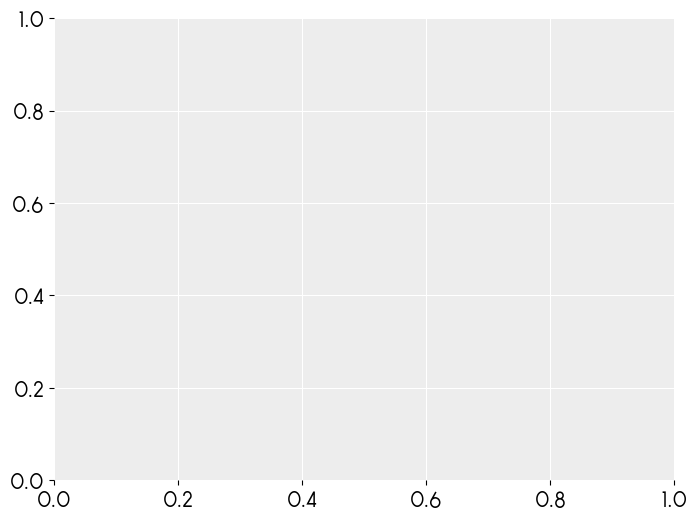

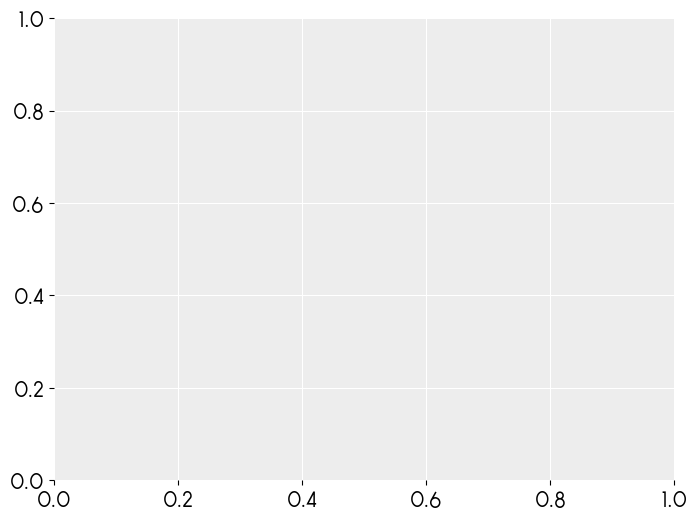

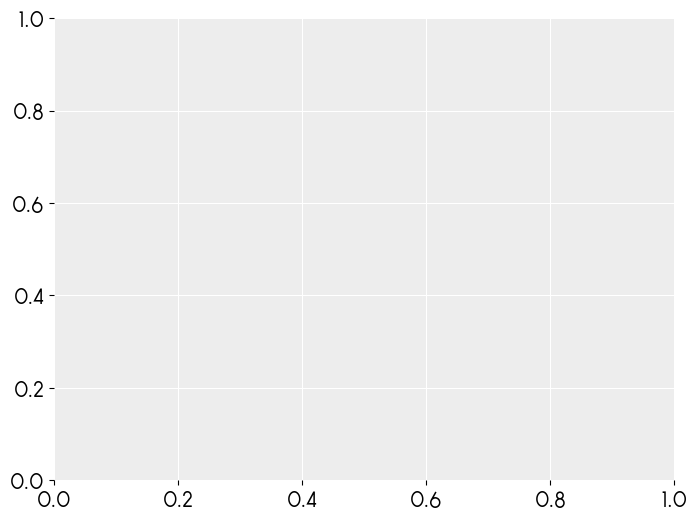

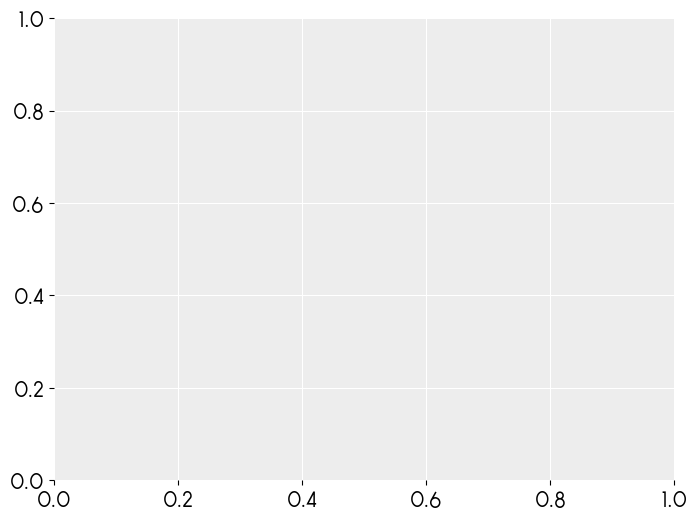

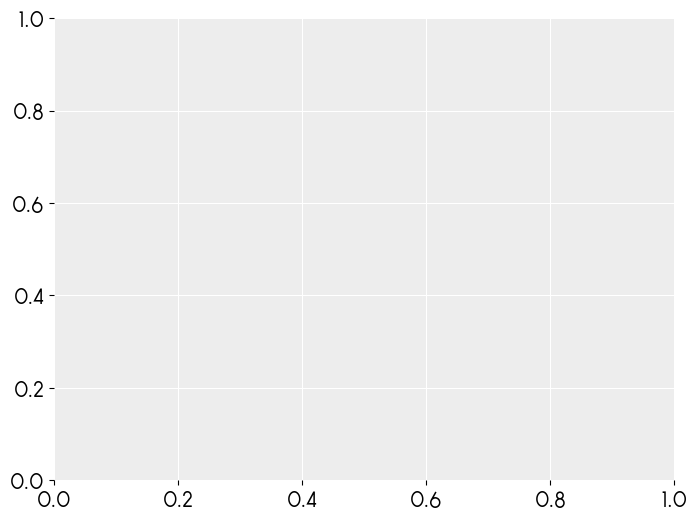

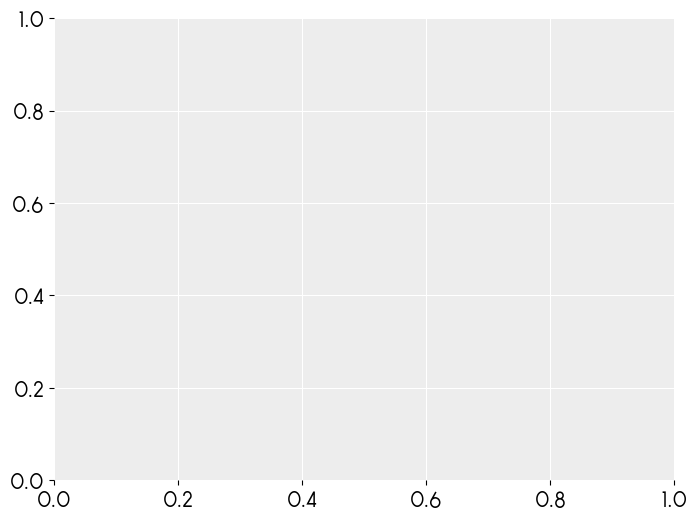

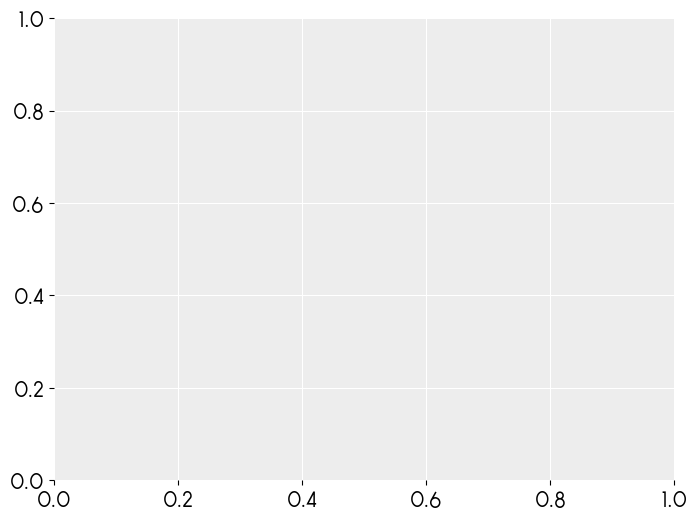

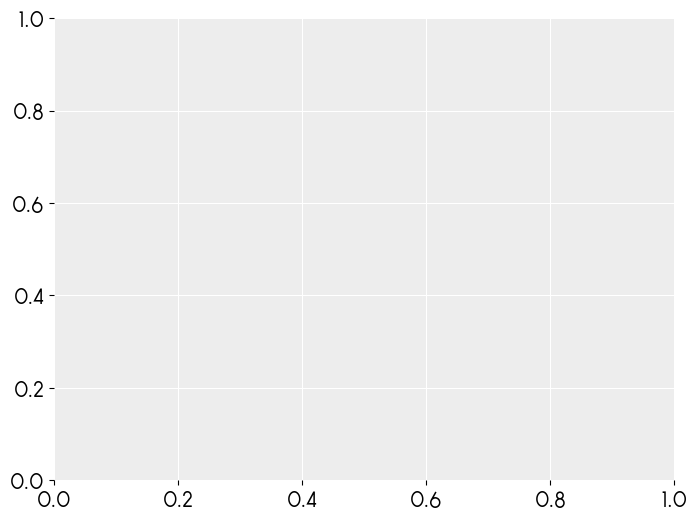

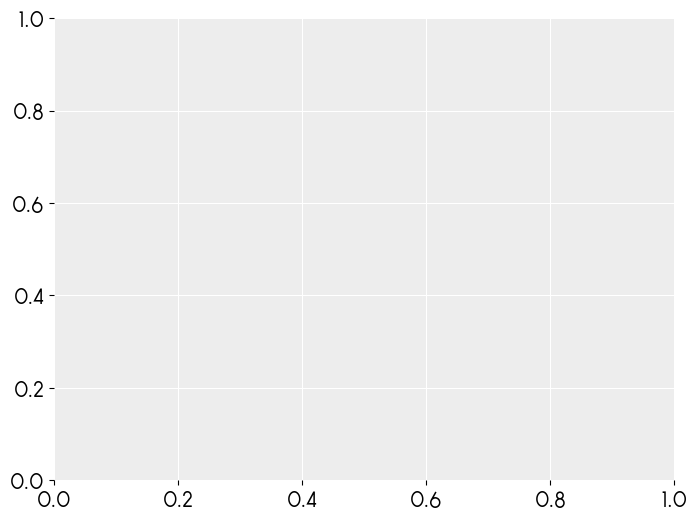

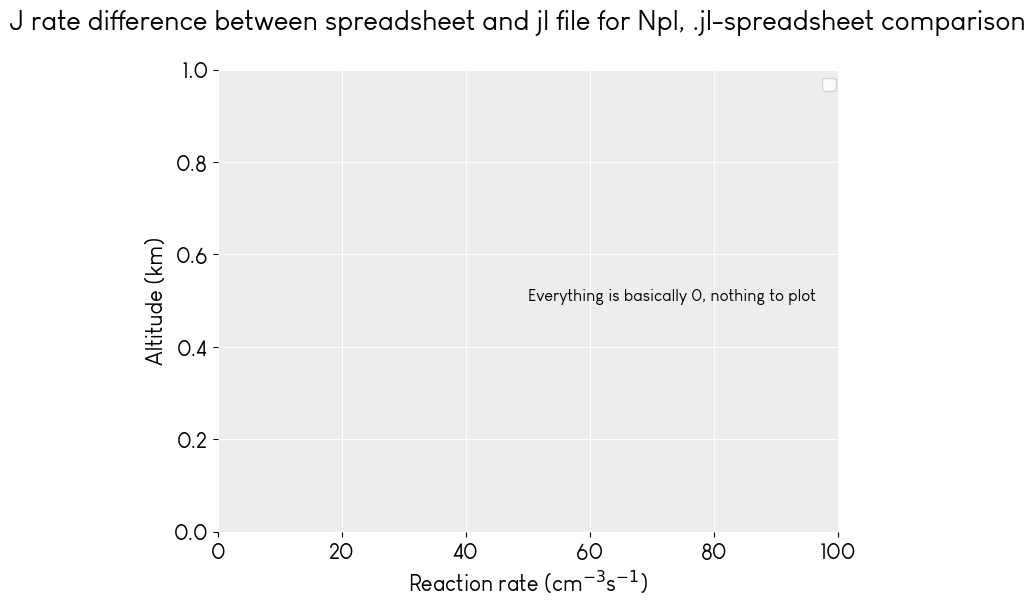

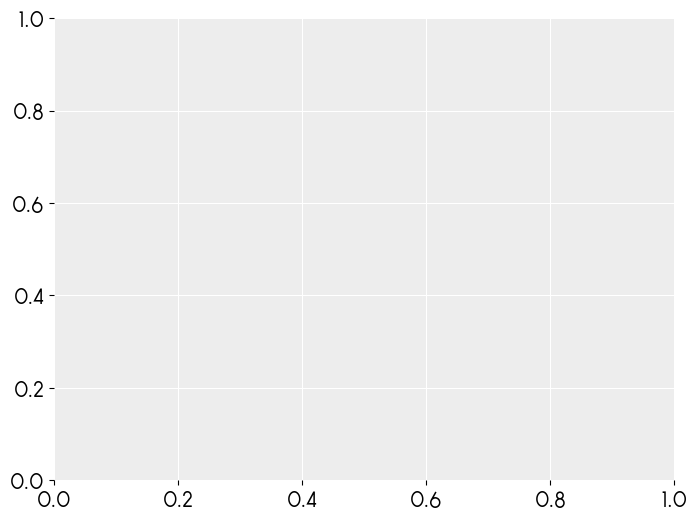

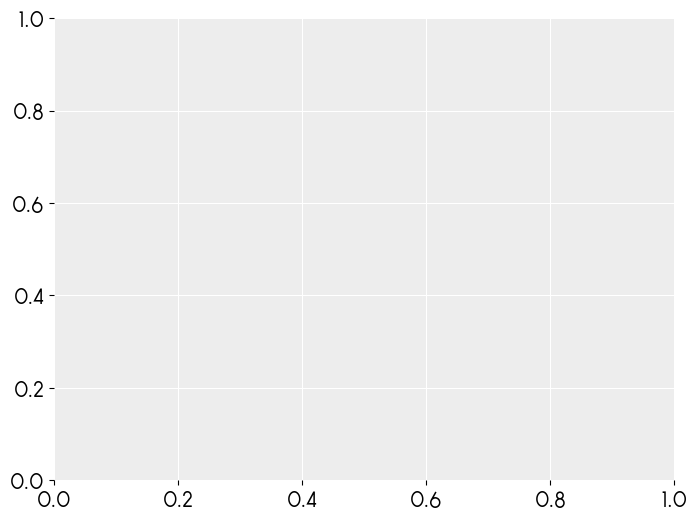

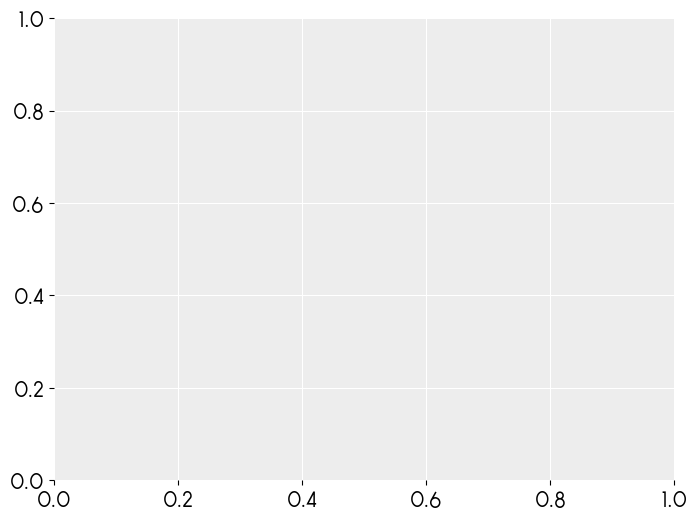

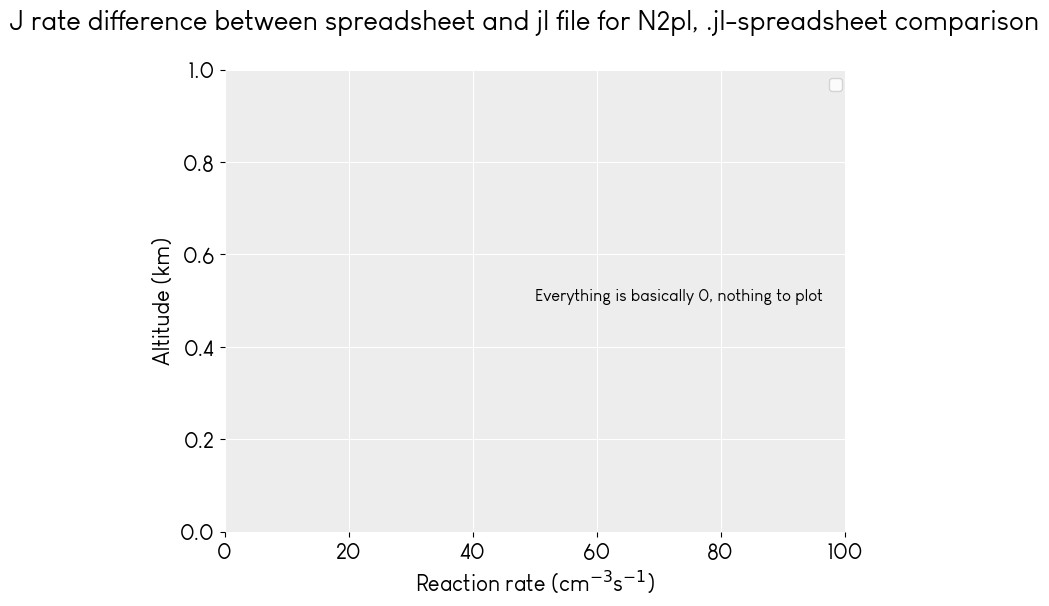

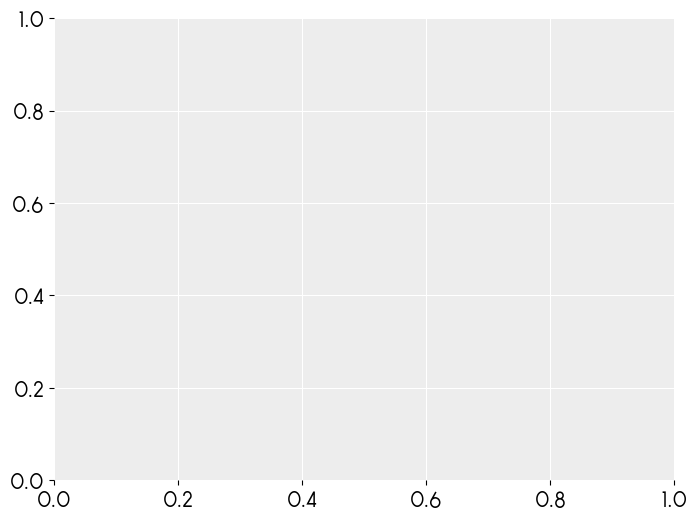

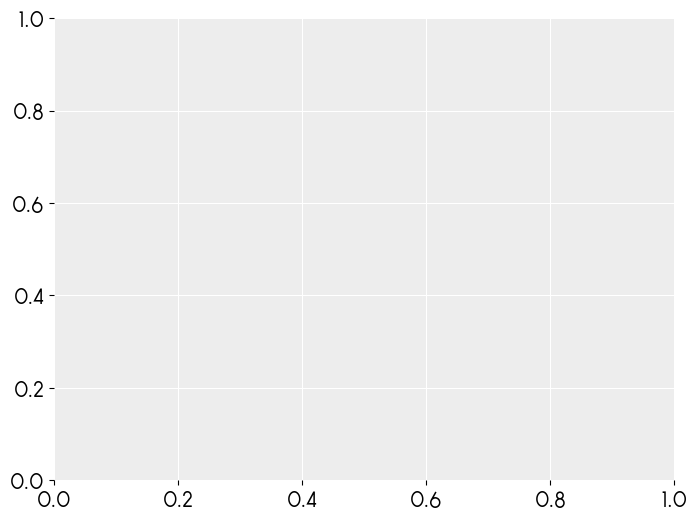

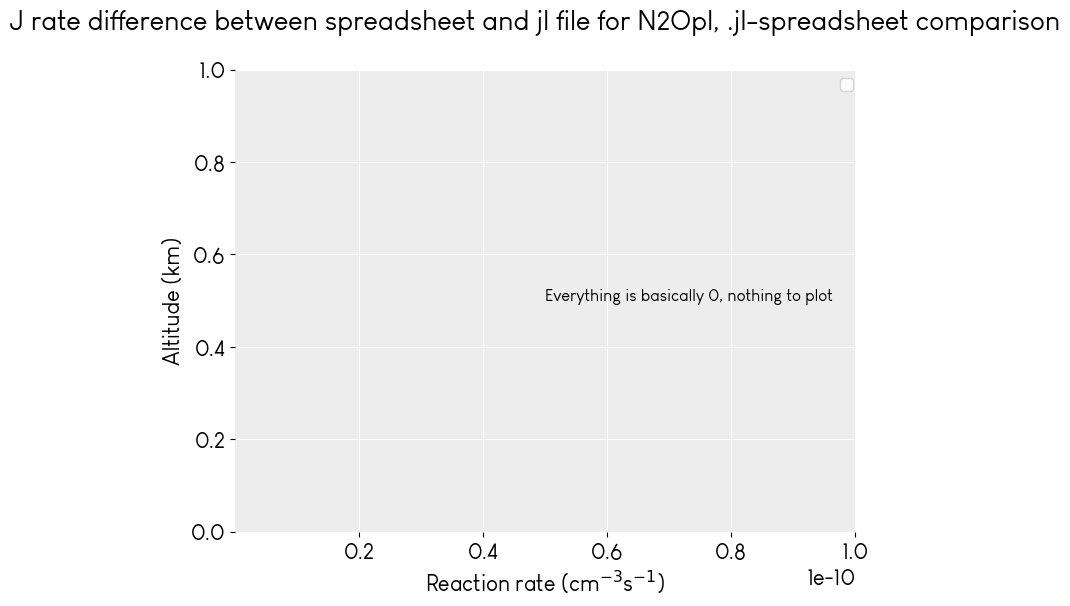

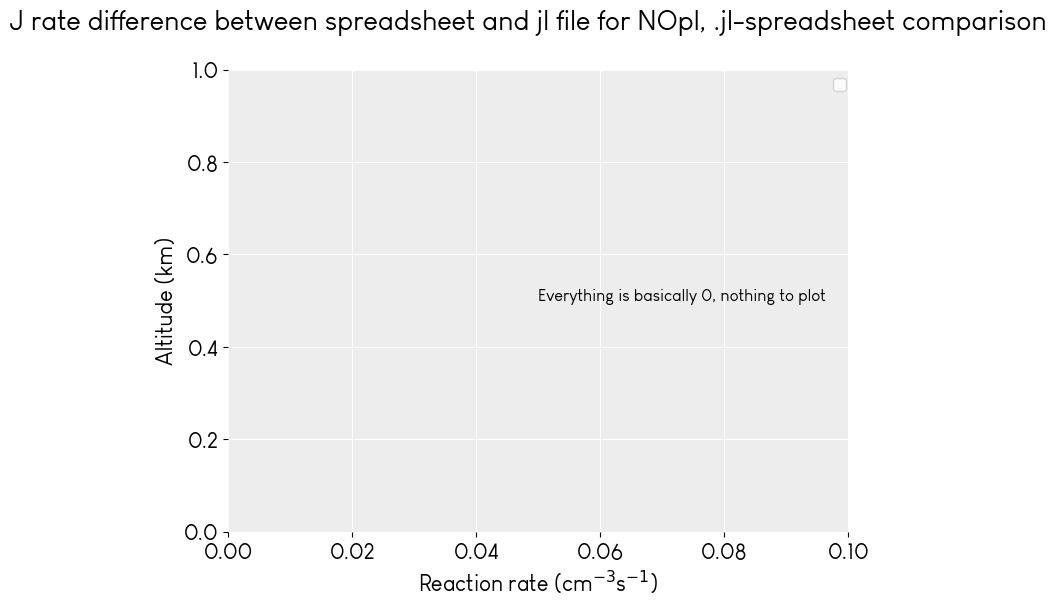

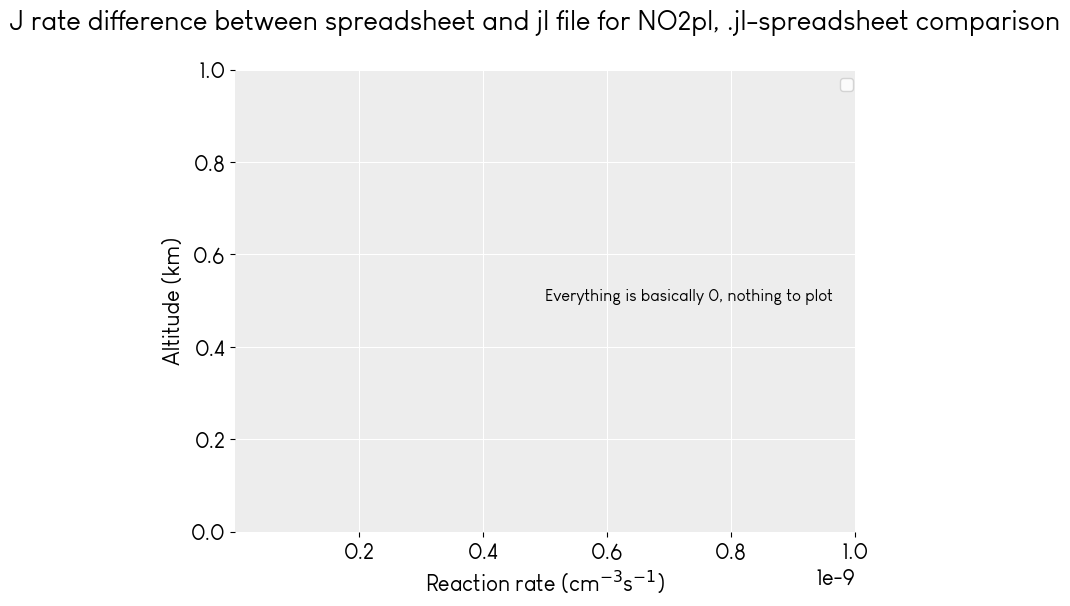

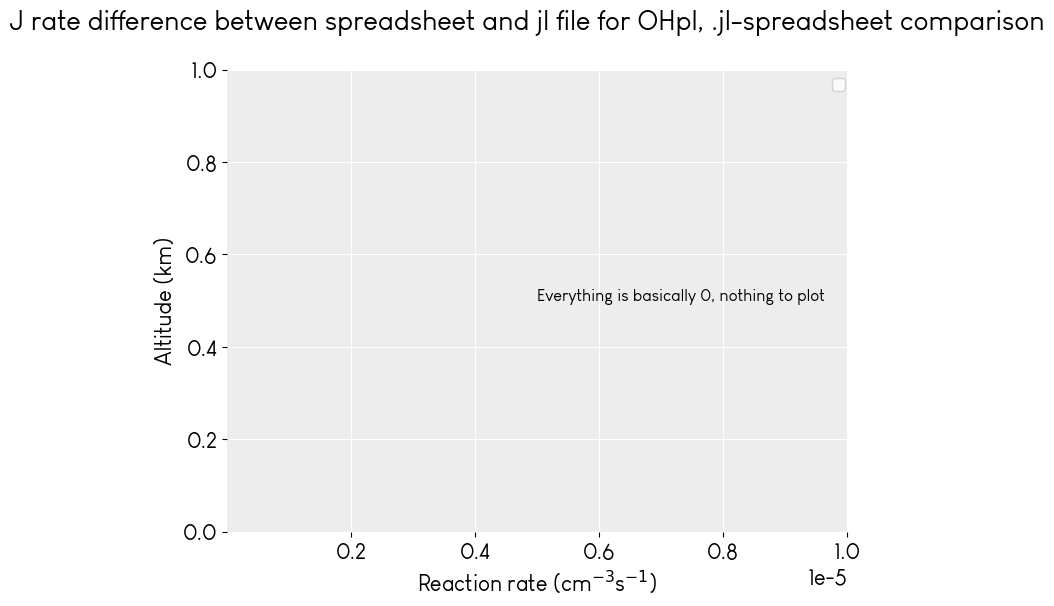

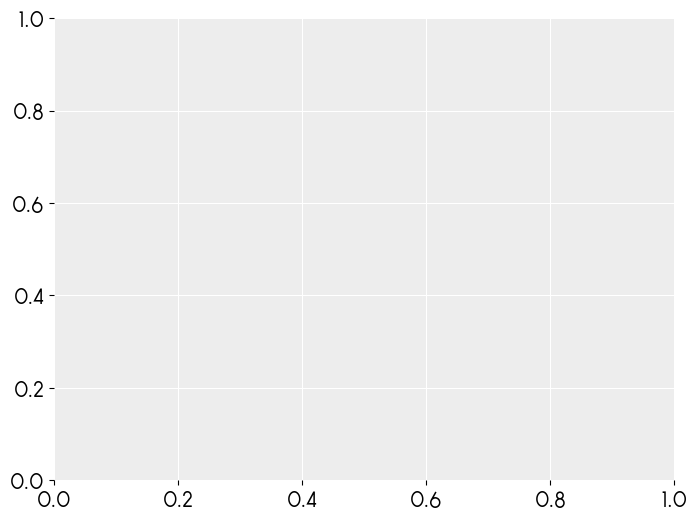

Ar has no photodissociation or photoionization reactions, no plot generated
CH has no photodissociation or photoionization reactions, no plot generated
CN has no photodissociation or photoionization reactions, no plot generated
HCN has no photodissociation or photoionization reactions, no plot generated
HCO has no photodissociation or photoionization reactions, no plot generated
HNO has no photodissociation or photoionization reactions, no plot generated
HOCO has no photodissociation or photoionization reactions, no plot generated
NH has no photodissociation or photoionization reactions, no plot generated
NH2 has no photodissociation or photoionization reactions, no plot generated
DCO has no photodissociation or photoionization reactions, no plot generated
DOCO has no photodissociation or photoionization reactions, no plot generated
HCO2pl has no photodissociation or photoionization reactions, no plot generated
DCO2pl has no photodissociation or photoionization reactions, no plot gener

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

In [35]:
for sp in all_species
    plot_Jrates(sp, nc, Tn_arr[2:end-1], Ti_arr[2:end-1], Te_arr[2:end-1], speciesbclist, all_species, ion_species, reaction_network, num_layers, plot_grid, 
                "/home/emc/OneDrive-CU/Research/UpperAtmoDH/Results/Jrates/", filenameext=".jl-spreadsheet comparison", source2=new_auto_reaction_network)
end

# Make plots to compare the k rates

In [48]:
a = [:H, :D, :M]
b = [:D, :H, :M]

3-element Vector{Symbol}:
 :D
 :H
 :M

In [98]:
# Loop through the new auto-network

function check_network_consistency()
    n = 1
    samesies = 0
    difference = 0

    matches = Dict([r=>false for r in new_auto_reaction_network])

    for new_rxn in new_auto_reaction_network
        # Search for the same reaction in the hand-coded network by comparing products and reactants
        for old_rxn in reaction_network

            if (sort(old_rxn[1]) == sort(new_rxn[1])) & (sort(old_rxn[2]) == sort(new_rxn[2]))

                # Set match flag to true for this reaciton
                matches[new_rxn] = true

                if occursin("J", string(new_rxn[3])) | occursin("Nup2D", string(new_rxn[1]))# | occursin("Nup2D", string(new_rxn[2]))  
                    # println("Skipping $(format_chemistry_string(new_rxn[1], new_rxn[2]))")
                    continue
                else
                    # collect the rates from both
                    newrate = :($(new_rxn[3]) .+ Tn .* 0) # this is just an idiot thing that has to be done to convince a a constant rate to be done over the array
                    oldrate = :($(old_rxn[3]) .+ Tn .* 0)

                    new_k = eval_rate_coef(nc, newrate, Tn_arr[2:end-1], Ti_arr[2:end-1], Te_arr[2:end-1], all_species, ion_species, num_layers)
                    old_k = eval_rate_coef(nc, oldrate, Tn_arr[2:end-1], Ti_arr[2:end-1], Te_arr[2:end-1], all_species, ion_species, num_layers)

                    # Plot rates on same axis 
                    try
                        @assert length(new_k)==length(plot_grid)
                    catch AssertionError
                        println(newrate)
                        println(oldrate)
                        throw("$(length(new_k)) != $(length(plot_grid))")
                    end
                    try
                        @assert length(old_k)==length(plot_grid)
                    catch AssertionError
                        println(newrate)
                        println(oldrate)
                        throw("$(length(old_k)) != $(length(plot_grid))")
                    end

                    if !all(x->x< new_k[1]/1000, new_k-old_k)
                        difference += 1
                        f = figure(figsize=(7,5))
                        plot(new_k, plot_grid, color="cornflowerblue", label="new, $(newrate)")
                        plot(old_k, plot_grid, color="red", label="old/handcoded, $(oldrate)")
                        xlabel("rate coefficient")
                        ylabel("altitude")
                        legend()
                        title(format_chemistry_string(new_rxn[1], new_rxn[2]))
                        savefig("rate_comp_plots/$(n).png")
                        n += 1 
                    else
                        samesies += 1
                    end
                end
            end
        end
    end
    
    # Now check that old network doesn't have any that new network doesn't have
    for old_rxn in reaction_network
        checked = 0 
        for new_rxn in new_auto_reaction_network
            if ((sort(old_rxn[1]) == sort(new_rxn[1])) & (sort(old_rxn[2]) == sort(new_rxn[2])))
                continue
            else 
                checked += 1
            end
        end
        
        if checked==length(new_auto_reaction_network)
            println("$(old_rxn) not in the spreadsheet!")
        end
    end
    
    println("$(samesies) reactions found to be the same between old and new network implementation, with $(difference) reactions having different rates")
    
    for k in keys(matches)
        if matches[k]==false
            println("No match found for reaction $(k)")
        end
    end
end

check_network_consistency (generic function with 1 method)

In [61]:
# this was before making the above a function.

No match found for reaction Any[[:CO2pl, :HD], [:CO2, :H, :D], 3.48e-10]
No match found for reaction Any[[:CH, :O], [:HCOpl, :E], :(4.2e-13 .* exp.(-850 ./ Tn))]
No match found for reaction Any[[:O2, :O, :N2], [:O3], :(5.0e-35 .* exp.(724 ./ Tn))]
No match found for reaction Any[[:HO2, :H], [:H2O, :O], 1.6e-12]
No match found for reaction Any[[:O, :O], [:O2], :(6.06789e-25 .* Tn .^ -3.25)]
No match found for reaction Any[[:O2, :O, :CO2], [:O3], :(1.32185e-27 .* Tn .^ -2.4)]
No match found for reaction Any[[:OD, :H2], [:H2O, :D], 0.0]


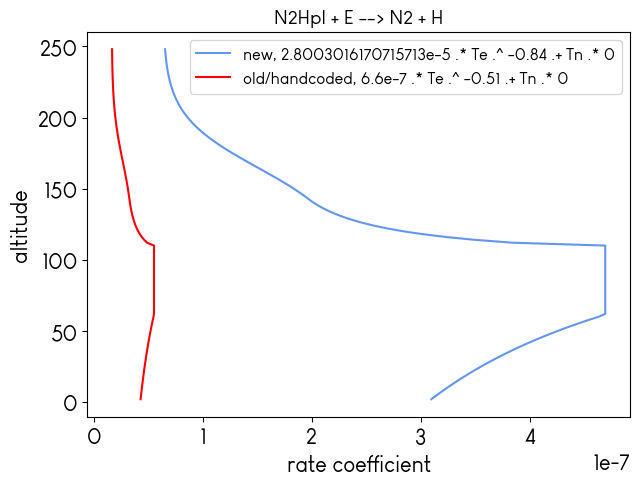

944 reactions found to be the same between old and new network implementation, with 1 reactions having different rates


In [99]:
check_network_consistency()

# older code

In [5]:
# function make_k_expr(A, B, C, T::String)
    
#     if (B == 0) & (C == 0) # constant rate coefficient
#         k = :($A)
#     elseif (B != 0) & (C == 0)
#         k = :($(A) .* $(Meta.parse(T)) .^ $(B))
#     elseif (B != 0) & (C != 0)
#         k = :($(A) .* $(Meta.parse(T)) .^ $(B) .* exp.($(C) ./ $(Meta.parse(T))))
#     elseif (B == 0) & (C != 0)
#         k = :($(A) .* exp.($(C) ./ $(Meta.parse(T))))
#     end
#     return k
# end


    

# function troe_parameter(k0, kinf, F)
#     #=
#     Put together a really nasty expression
#     =#
#     outer_numer = :(log10.($(F)))
#     inner_numer = :(log10.(($(k0) .* M) ./ ($(kinf))) .- 0.4 .- 0.67 .* log10.($(F)))
#     inner_denom = :(0.75 .- 1.27 .* log10.($(F)) .- 0.14 .* (log10.(($(k0) .* M) ./ ($(kinf))) .- 0.4 .- 0.67 .* log10.($(F))))
#     outer_denom = :(1 .+ (($(inner_numer)) ./ ($(inner_denom))) .^ 2)
#     FF = :(10 .^ (($(outer_numer)) ./ ($(outer_denom))))
#     return FF
# end


# function make_Troe(k0_ABC, kinf_ABC, F)
#     #=
#     k0_ABC and kinf_ABC are lists of A, B, and C for k0 and kinf.
#     =#
#     k0 = make_k_expr(k0_ABC..., "Tn")
#     kinf = make_k_expr(kinf_ABC..., "Tn")
    
#     if F == 0
#         return :(($(k0) .* $(kinf) .* M) ./ ($(k0) .* M .+ $(kinf)))  # Updated to match Roger's code 4 Feb 2021
#     else        
#         FF = troe_parameter(k0, kinf, F)
#         return :($(FF) .* ($(k0) .* $(kinf)) ./ ($(k0) .* M .+ $(kinf)))  # Updated to match Roger's code 5 Feb 2021
#     end
# end

# function make_modified_Troe(k0_ABC, kinf_ABC, kR_ABC, F)
#     #=
#     "Type 4" pressure dependent association reactions. 
#     Roger has the result for F=0 in his code as k_tot = k2 + k0*kinf*M/(k0*M+kinf), with k2 (kR in the appendix from Vuitton)
#     being the general form and using the third set of A, B, C coefficients in his file. Those columns are 0 in the file he gave me, but
#     I have coded it like this though to make sure to keep the form in case I ever get one where it's not 0.
    
#     k0_ABC and kinf_ABC are lists of A, B, and C for k0 and kinf. F is the Troe parameter. 
#     =#
#     k0 = make_k_expr(k0_ABC..., "Tn")
#     kinf = make_k_expr(kinf_ABC..., "Tn")
#     kR = make_k_expr(kR_ABC..., "Tn")
    
#     if F == 0
#         return :($(kR) .+ ($(k0) .* $(kinf) .* M) ./ ($(k0) .* M .+ $(kinf)))
#     else
#         FF = troe_parameter(k0, kinf, F)
        
#         # for this one, we need the minimum of k_inf and a more complicated expression.
#         # Format for minimum of A and B is: :(min.($:(A), $:(B)))
#         return :(min.($:($kinf), $:($(kR) .+ ($(FF) .* $(k0) .* $(kinf) .* M) ./ ($(k0) .* M .+ $(kinf)))))
#     end
# end

# function all_reactants_used(d, used_species)
#     #=
#     Filter out reactions with reactants we won't use 
#     =# 
    
#     r1 = Symbol(d["R1"])
#     r2 = Symbol(d["R2"])
    
#     unused = []

#     if !(r1 in used_species)
#         push!(unused, r1)
#         return false
#     else  # if the first reactant is used
#         if d["R2"] != "-0"
#             if !(r2 in used_species)
#                 push!(unused, r2)
#                 return false
#             else
#                 return true
#             end 
#         else
#             return true
#         end
#     end

#     println("Deleted all reactions containing these species: $(unused)")
# end

# function format_neutral_network(neutralfile)
#     #=
#     Construct array of the neutral network.
    
#     =#
    
#     # Load the neutral network, replace missing values
#     ntable = CSV.File(neutralfile) |> DataFrame
#     replace!(ntable."P2", missing => "-0");
#     replace!(ntable."P3", missing => "-0");
#     select!(ntable, Not(:Column1))  # Ignore the index column
    
#     ntable = filter(all_reactants_used, ntable)
    
#     # Set up the array to store neutral network 
#     numrows = size(ntable)[1]
#     neutral_network = Array{Any}(undef, numrows, 1)

#     # identify the type and sort into lists
#     type1 = Any[]
#     type2 = []
#     type3 = []
#     type4 = []
#     type5 = []
    
#     # Fill the network
    
#     for i in range(1, stop=numrows)
#         # set up the reaction
#         reactants = [Symbol(j) for j in filter!(j->j!="-0", [ntable[i, "R1"], ntable[i, "R2"]])]
#         products = [Symbol(j) for j in filter!(j->j!="-0", [ntable[i, "P1"], ntable[i, "P2"], ntable[i, "P3"]])]

#         # Type 1: Pressure independent unimolecular rxns, high pressure limit
#         # use k (which is same as k inf); units s^-1
#         if ntable[i, "type"]==1
#             push!(type1, [reactants, products, :($(make_k_expr(ntable[i, "kA"], ntable[i, "kB"], ntable[i, "kC"], "Tn")))   ])

#         # Type 2: P independent bimolecular; use k (same as *k inf), units cm^3 s^-1
#         elseif ntable[i, "type"]==2
#             push!(type2, [reactants, products, make_k_expr(ntable[i, "kA"], ntable[i, "kB"], ntable[i, "kC"], "Tn")])

#         # Type 3: P dependent bimolecular.
#         elseif ntable[i, "type"]==3
#             push!(type3, [reactants, products, 
#                           make_Troe([ntable[i, "k0A"], ntable[i, "k0B"], ntable[i, "k0C"]], 
#                                    [ntable[i, "kA"], ntable[i, "kB"], ntable[i, "kC"]],
#                                     ntable[i, "F"])
#                           ])

#         # Type 4: P dependent association rxns
#         elseif ntable[i, "type"]==4
#             push!(type4, [reactants, products, 
#                           make_modified_Troe([ntable[i, "k0A"], ntable[i, "k0B"], ntable[i, "k0C"]], 
#                                              [ntable[i, "kA"], ntable[i, "kB"], ntable[i, "kC"]],
#                                              [ntable[i, "kradA"], ntable[i, "kradB"], ntable[i, "kradC"]],
#                                              ntable[i, "F"])

#                          ])

#         # Type 5: special forms for OH+CO -> H + CO2, OH+CO -> HOCO
#         elseif ntable[i, "type"]==5
#             push!(type5, [reactants, products, make_k_expr(ntable[i, "k0A"], ntable[i, "k0B"], ntable[i, "k0C"], "Tn"), 
#                                                make_k_expr(ntable[i, "kA"], ntable[i, "kB"], ntable[i, "kC"], "Tn")])

#         else
#             println("Got an unexpected type! $(ntable[i, "type"])")
#         end
#     end
    
#     return type1, type2, type3, type4, type5
    
# end


format_ion_network (generic function with 1 method)

In [ ]:
for i in range(1, stop=numrows)
    # set up the reaction
    reactants = [neutral_table[i, "R1"], neutral_table[i, "R2"]]
    reactants = filter!(j->j!="-0", reactants)
    reactants = [Symbol(j) for j in reactants]
    products = [neutral_table[i, "P1"], neutral_table[i, "P2"], neutral_table[i, "P3"]]
    products = filter!(j->j!="-0", products)
    products = [Symbol(j) for j in products]
    
    # Type 1: Pressure independent unimolecular rxns, high pressure limit
    # use k (which is same as k inf); units s^-1
    if neutral_table[i, "type"]==1
        push!(type1, [reactants, products, Symbol(make_general_k(neutral_table[i, "kA"], neutral_table[i, "kB"], neutral_table[i, "kC"]))])
        
    # Type 2: P independent bimolecular; use k (same as *k inf), units cm^3 s^-1
    elseif neutral_table[i, "type"]==2
        push!(type2, [reactants, products, Symbol(make_general_k(neutral_table[i, "kA"], neutral_table[i, "kB"], neutral_table[i, "kC"]))])
        
    # Type 3: P dependent bimolecular.
    elseif neutral_table[i, "type"]==3
        push!(type3, [reactants, products, 
                      make_Troe([neutral_table[i, "k0A"], neutral_table[i, "k0B"], neutral_table[i, "k0C"]], 
                               [neutral_table[i, "kA"], neutral_table[i, "kB"], neutral_table[i, "kC"]],
                                neutral_table[i, "F"])
                      ])
        
    # Type 4: P dependent association rxns
    elseif neutral_table[i, "type"]==4
        push!(type4, [reactants, products, 
                      make_modified_Troe([neutral_table[i, "k0A"], neutral_table[i, "k0B"], neutral_table[i, "k0C"]], 
                                         [neutral_table[i, "kA"], neutral_table[i, "kB"], neutral_table[i, "kC"]],
                                         [neutral_table[i, "kradA"], neutral_table[i, "kradB"], neutral_table[i, "kradC"]],
                                         neutral_table[i, "F"])
                
                     ])
        
    # Type 5: special forms for OH+CO -> H + CO2, OH+CO -> HOCO
    elseif neutral_table[i, "type"]==5
        push!(type5, [reactants, products, Symbol(make_general_k(neutral_table[i, "k0A"], neutral_table[i, "k0B"], neutral_table[i, "k0C"])), 
                                           Symbol(make_general_k(neutral_table[i, "kA"], neutral_table[i, "kB"], neutral_table[i, "kC"]))])

    else
        println("Got an unexpected type! $(neutral_table[i, "type"])")
    end
end


    
println("Type 1:")
for entry in type1
    println(entry)
end
println()
println("Type 2:")
for entry in type2
    println(entry)
end
println()
println("Type 3:")
for entry in type3
    println(entry)
end
println()
println("Type 4:")
for entry in type4
    println(entry)
    println()
end
println("Type 5:")
for entry in type5
    println(entry)
end
# println(neutral_network)


Type 1:
Any[[:O1D], [:O], Symbol("0.0051")]

Type 2:
Any[[:C, :C], [:C2], Symbol("2.16e-11")]
Any[[:C, :H], [:CH], Symbol("1.0e-17")]
Any[[:C, :N], [:CN], Symbol("6.93e-20 .* (Tn .^ 0.37) .* exp.(-51.0 ./ Tn)")]
Any[[:CH, :C], [:C2, :H], Symbol("6.59e-11")]
Any[[:CH, :H], [:H2, :C], Symbol("1.31e-10 .* exp.(-80.0 ./ Tn)")]
Any[[:CH, :H2], [:CH2, :H], Symbol("2.9e-10 .* exp.(-1670.0 ./ Tn)")]
Any[[:CH, :H2], [:CH3], Symbol("2.92e-16 .* (Tn .^ -0.71) .* exp.(-11.6 ./ Tn)")]
Any[[:CH, :N], [:CN, :H], Symbol("2.77e-10 .* (Tn .^ -0.09)")]
Any[[:CH, :O], [:CO, :H], Symbol("6.6e-11")]
Any[[:CH, :O], [:HCOP, :E], Symbol("4.2e-13 .* exp.(-850.0 ./ Tn)")]
Any[[:CH, :O], [:OH, :C], Symbol("2.52e-11 .* exp.(-2381.0 ./ Tn)")]
Any[[:CN, :H2], [:HCN, :H], Symbol("1.8e-19 .* (Tn .^ 2.6) .* exp.(-960.0 ./ Tn)")]
Any[[:CN, :N], [:N2, :C], Symbol("9.8e-10 .* (Tn .^ -0.4)")]
Any[[:CN, :NH], [:HCN, :N], Symbol("1.7e-13 .* (Tn .^ 0.5) .* exp.(-1000.0 ./ Tn)")]
Any[[:CN, :O], [:CO, :N], Symbol("5.0e-11 .* ex

## getting minimum() to evaluate within symbolic expressions

In [61]:
T = [100, 200, 300]
println(1.0 .* T .^ 0)

T = 100
println(1.0 .* T .^ 0)

[1.0, 1.0, 1.0]
1.0


In [62]:
T = [100, 200, 300]
test = :(minimum([$:(1.0), $:(1.4e-10 .* (T .^ 0.4) .* exp.(-160 ./ T))]))
eval(test)

LoadError: MethodError: no method matching isless(::Array{Float64,1}, ::Float64)
Closest candidates are:
  isless(!Matched::Float64, ::Float64) at float.jl:465
  isless(!Matched::Missing, ::Any) at missing.jl:87
  isless(!Matched::AbstractFloat, ::AbstractFloat) at operators.jl:165
  ...

In [71]:
T = [100, 200, 300]
test = :(minimum([$:(1.0 .* T .^ 0), $:(1.4e-10 .* (T .^ 0.4) .* exp.(-160 ./ T))]))
eval(test)

3-element Array{Float64,1}:
 1.7834332719518747e-10
 5.237263783560956e-10
 8.041791591659083e-10

But what if the values which are lowest change per element? Here is a very simple example:

In [80]:
# The return should be a 5 element array with values 1, 2, 3, 3, 3.
quoted = quote
    min.([1, 2, 3, 4, 5], [3, 3, 3, 3, 3])
end

eval(quoted)

5-element Array{Int64,1}:
 1
 2
 3
 3
 3

Now to get it to work with a more complicated expression that generates an array.

In [81]:
T = [100, 121, 144, 169, 196, 225]
# sqrts: [10, 11, 12, 13, 14, 15]
# Comparing with an array of 12s, the result should be: [10, 11, 12, 12, 12, 12]

uglyexpr = quote
   min.(12. .* T .^ 0, T .^ 0.5)  
end

eval(uglyexpr)

6-element Array{Float64,1}:
 10.0
 11.0
 12.0
 12.0
 12.0
 12.0

Simplify the syntax:

In [85]:
T = [100, 121, 144, 169, 196, 225]
test = :( min.( $:(12. .* T .^ 0), $:(T .^ 0.5) ) )
eval(test)

6-element Array{Float64,1}:
 10.0
 11.0
 12.0
 12.0
 12.0
 12.0

Make sure it works when what's passed in is NOT an array:

In [86]:
T = 169
test = :( min.( $:(12. .* T .^ 0), $:(T .^ 0.5) ) )
eval(test)

12.0

In [87]:
T = 100
test = :( min.( $:(12. .* T .^ 0), $:(T .^ 0.5) ) )
eval(test)

10.0

Cool. This is what we will use, which means I need to fix the syntax I already introduced. This just requires me to replace `minimum` with `min.` and remove the square brackets in the PARAMETERS.jl file. But, it also means I need to reconverge the C, CH, HCO neutrals because they were done with an incorrect expresison.

## neutral rate coeff functions old versions



In [37]:
function make_general_k_old(A, B, C)
    #=
    returns a string for the general rate coefficient form 
    k = A * (T^B) * exp(C/T)
    checked: 4 Feb 2021
    =#
    
    k_A = string(A)
    if B != 0
        k_B = " .* (Tn .^ $(B))"
    else
        k_B = ""
    end
    if C != 0
        k_C = " .* exp.($(C) ./ Tn)"
    else
        k_C = ""
    end
    
    return k_A * k_B * k_C
end

function troe_parameter_old(k0, kinf, F)
    #=
    Put together a really nasty expression
    =#
    outer_numer = "log10.($(F))"
    inner_numer = "log10.(($(k0) .* M) ./ ($(kinf))) .- 0.4 .- 0.67 .* log10.($(F))"
    inner_denom = "0.75 .- 1.27 .* log10.($(F)) .- 0.14 .* (log10.(($(k0) .* M) ./ ($(kinf))) .- 0.4 .- 0.67 .* log10.($(F)))"
    outer_denom = "1 .+ (($(inner_numer)) ./ ($(inner_denom))) .^ 2"
    FF = "10 .^ (($(outer_numer)) ./ ($(outer_denom)))"
    return FF
end


function make_Troe_old(k0_ABC, kinf_ABC, F)
    #=
    k0_ABC and kinf_ABC are lists of A, B, and C for k0 and kinf.
    =#
    k0 = make_general_k(k0_ABC...)
    kinf = make_general_k(kinf_ABC...)
    
    if F == 0
        return Symbol("($(k0) .* $(kinf) .* M) ./ ($(k0) .* M .+ $(kinf))")  # Updated to match Roger's code 4 Feb 2021
        # old formula that was wrong: return Symbol(0)
    else        
        FF = troe_parameter(k0, kinf, F)
        return Symbol("$(FF) .* ($(k0) .* $(kinf)) ./ ($(k0) .* M .+ $(kinf))")  # Updated to match Roger's code 5 Feb 2021
        #old formula that was wrong: return Symbol("$(string(F)) * $(kinf) * $(k0) * M / ($(kinf) + $(k0) * M)")
    end
end

function make_modified_Troe_old(k0_ABC, kinf_ABC, kR_ABC, F)
    #=
    "Type 4" pressure dependent association reactions. 
    Roger has the result for F=0 in his code as k_tot = k2 + k0*kinf*M/(k0*M+kinf), with k2 (kR in the appendix from Vuitton)
    being the general form and using the third set of A, B, C coefficients in his file. Those columns are 0 in the file he gave me, but
    I have coded it like this though to make sure to keep the form in case I ever get one where it's not 0.
    
    k0_ABC and kinf_ABC are lists of A, B, and C for k0 and kinf.
    =#
    k0 = make_general_k(k0_ABC...)
    kinf = make_general_k(kinf_ABC...)
    kR = make_general_k(kR_ABC...)

    # old formula that was wrong: return Symbol("$(kR) + $(F) * ($(kinf) - $(kR)) * $(k0) * M / ($(kinf) - $(kR) + $(k0) * M)")
    if F == 0
        return Symbol("$(kR) .+ ($(k0) .* $(kinf) .* M) ./ ($(k0) .* M .+ $(kinf))")
    else
        FF = troe_parameter(k0, kinf, F)
        
        # for this one, we need the minimum of the following two expressions. Because of the weird way I have to do this, I will add
        # :(minimum([$:(A), $:(B)])) around the two returned items A and B once it returns its stuff.
        return Symbol("$(kinf)"), Symbol("$(kR) .+ ($(FF) .* $(k0) .* $(kinf) .* M) ./ ($(k0) .* M .+ $(kinf))")
    end
end


make_modified_Troe_old (generic function with 1 method)